In [1]:
#===================================================================================================
# Main calculations - for SpEs etc, and crit freq
#===================================================================================================


import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
from cftime import datetime 
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
#jet = mcm.get_cmap('jet')
jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')

import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
import time
from time import process_time
%matplotlib inline 
#import line_profiler
#%load_ext line_profiler

#===================================================================================================
start_time = time.process_time() 
#===================================================================================================


#/////////////////////////////////////////////////////////////////////////////////////////////////////////
#////////////////////////////  Things to check/change before running  ////////////////////////////////////
#/////////////////////////////////////////////////////////////////////////////////////////////////////////

crit_freq_on = 1
#--------------------------------------------------------------------------------------------------

#ds_months = ['12','01','02']
#Monthstr = [ 'Dec', 'Jan', 'Feb' ]

ds_months = ['06','07','08']
Monthstr = [ 'Jun', 'Jul', 'Aug' ]

#ds_months = ['06','07']
#Monthstr = ['Jun','Jul']

#ds_months = ['06']
#Monthstr = ['Jun']
#--------------------------------------------------------------------------------------------------
time_ar_2wk = np.arange(0,2)

times_str_min = np.array( (time_ar_2wk,time_ar_2wk,time_ar_2wk) , dtype=str  ) 
times_str_max = np.array( (time_ar_2wk,time_ar_2wk,time_ar_2wk) , dtype=str  ) 
#times_str_min = np.array( (time_ar_2wk,time_ar_2wk) , dtype=str  ) 
#times_str_max = np.array( (time_ar_2wk,time_ar_2wk) , dtype=str  ) 
#times_str_min = np.array( (time_ar_2wk) , dtype=str  ) 
#times_str_max = np.array( (time_ar_2wk) , dtype=str  ) 

#--------------------------------------------------------------------------------------------------

run_name = 'Jianfei_run'
Metal='Fe'

#run_name = 'Wuhu_IonTr_run'    
#run_name = 'Wuhu_IonTr_run_6m'  
#Metal = 'Si'

'''////////////////  Additional Checks before running  ////////////////

- Check file paths below are correct for datasets
- Check Monthfolderstr is correct (i.e. set manually if doing one month only)
- Check lev_sl_idx_min/max are set to chosen heights (currently ~80-130km). 
        If changing this, N.B some of the [plotting code](?) is set to 25 levs rather than responding if the no of sliced levs changes


- Check Time parameters are correct (time_it_shape, time_ind_2wk_min, time_ind_2wk_max, time_shape) 
        Currently set to iterate over 2x 2wk time slices per month. Each time slice is 336 long. N.B. offset array is set up for 2x2wk periods per mth
'''

#/////////////////////////////////////////////////////////////////////////////////////////////////////////
#/////////////////////////////////////////////////////////////////////////////////////////////////////////
#/////////////////////////////////////////////////////////////////////////////////////////////////////////

Monthfolderstr = Monthstr[0] + '-' + Monthstr[-1]
#Monthfolderstr = 'Jun-Aug'

ds_months_shape = len(ds_months)  #3
ds_months_ar = np.arange(0,ds_months_shape)   #[0,1,2]
#--------------------------------------------------------------------------------------------------

#Set time parameters - No of time samples to iterate over (2x 2 week periods)
time_it_shape = 2   
time_ind_2wk_min = [  0, 336]
time_ind_2wk_max = [335, 671]

#Set time parameters - No of timesteps in one time sample (2 week period)
time_shape = 336
timear = np.arange(0,time_shape) # 2 week period (hourly data)
#--------------------------------------------------------------------------------------------------

lon_shape = 144
lonar = np.arange(0,lon_shape)        
it_arr = np.arange(0,48) # array 0->47   #0.5h LT bins
it_ar = np.arange(1,48) # array 1->47 # Used to bin LT (144x 10 min bins) into 0.5h LT bins. N.B. Starting from index1 as index0 is calculated differently

lat_shape = 96
latar= np.arange(0,lat_shape)

#Lat grid in 1' increments
newlat = np.arange(-89.5,90.5,1)
newlat_shape = 180
#weights_newlat = np.cos(np.deg2rad(newlat))

#Lat grid in 5' slices (each index is centrepoint of slice)
intlat = np.arange(-87.5,92.5,5)
intlat_shape = 36
intlat_ar = np.arange(0,intlat_shape)  # array 0->35

# Slice arrays (lev, altitude) between chosen range
lev_sl_idx_min = 42
lev_sl_idx_max = 66
lev_shape = (lev_sl_idx_max-lev_sl_idx_min)+1 #25
levar = np.arange(0,lev_shape) #0-24
#--------------------------------------------------------------------------------------------------

# Create an array with offset needed for each UT time step (24h period)
# Offset by 15 degrees lon each time, lon axis is in 2.5 degree intervals
offset =  np.arange(0,24) * 15 / 2.5 
offset = offset.astype(int)

# Stack multiple offset arrays to create offsets for consecutive days in the 2 week dataset 
#offset = np.stack((offset, offset, offset, offset, offset, offset, offset, offset, offset, offset, offset, offset, offset, offset), axis=0)   #2wks
#offset = np.reshape(offset, (168*2))
offset = np.tile(offset, 2 * 168)
#--------------------------------------------------------------------------------------------------

#------------------ Variables for selection criteria ----------------------------------------------
sigma_val = 1   #1sigma~68%   1.5sigma~87%   2sigma~95%
sigma_val_str = str(sigma_val)

Crit_name = '(B)' # Current criteria name
#--------------------------------------------------------------------------------------------------

#=================================  Defining Variables  ===========================================

Mptdens_sh = np.ndarray((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) #(25, 336, 96, 144, 2, 3)  #Metal density in local time
#Mptdens_w_sh = np.ndarray((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) #(25, 336, 96, 144, 2, 3) #lat-weighted - not using
Mptdens_diff = np.ndarray((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)   #Difference between Metal density and average

SpEs_sh_nan = np.empty((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape))  
SpEs_sh_nan[:] = np.NaN #An array the same size as SpEs_sh filled with NaNs. Used for seletion criteria calculation

Mptdens_avg_temp = np.empty((lev_shape, lat_shape, 3, time_it_shape, ds_months_shape), dtype=float)  #Temporary array used in calculation rebinning from 10min -> 30 min LT bins
Mptdens_avg_b = np.empty((lev_shape, lat_shape, 48, time_it_shape, ds_months_shape), dtype=float)    #10 min bins (144 lon) -> 30 min bins (48 lon)
#-------------------------------------------------
Mptdens_avv1_b = np.empty((lev_shape, newlat_shape, time_it_shape, ds_months_shape), dtype=float)   #Mptdens_avv1 interpolated onto 1' lat array
#Mptdens_avv1_b_w = np.empty((lev_shape, newlat_shape, time_it_shape, ds_months_shape), dtype=float) #lat weighted - not using

Mptdens_avv1_b_5d = np.empty((lev_shape, intlat_shape, time_it_shape, ds_months_shape), dtype=float) #Average M+ density in 5' lat slices (as ft of lev)
max_Mptdens_avv1_b_5d = np.empty((intlat_shape, time_it_shape, ds_months_shape), dtype=float)        #Max of Mptdens_avv1_b_5d over lev dim

#Equivalent to Mptdens_avv1_b_5d and max_Mptdens_avv1_b_5d but assigned to the correct index on a normal 96-long lat axis (so can use these in selectin criteria)
Mptdens_avv1b5d_l = np.empty((lev_shape, lat_shape, time_it_shape, ds_months_shape), dtype=float) 
max_Mptdens_avv1b5d_l = np.empty((lat_shape, time_it_shape, ds_months_shape), dtype=float) 
#-------------------------------------------------
Mptdens_avg_bb = np.empty((lev_shape, newlat_shape, 48, time_it_shape, ds_months_shape), dtype=float)  #binned into 30 min LT bins and binned into 1' lat slices
#Mptdens_avg_bb_w = np.empty((lev_shape, newlat_shape, 48, time_it_shape, ds_months_shape), dtype=float) #lat weighted - not using

Mptdens_avg_bb_5d = np.empty(  (lev_shape,intlat_shape, 48, time_it_shape, ds_months_shape )   , dtype=float )  #Mptdens_avg_b binned into 30 min LT bins and averaged in 5' lat slices
Mptdens_avg_bb_5d_avg = np.empty((lev_shape, intlat_shape, 48, ds_months_shape), dtype=float)   #Monthly avg at each height/lat/lon
Mptdens_avg_bb_5d_avglev = np.empty((intlat_shape, 48, ds_months_shape), dtype=float)  #Monthly avg over all levs
Mptdens_avg_bb_5d_dsavg = np.ndarray((lev_shape, intlat_shape, 48), dtype = float)   #Dataset avg at each height/lat/lon
Mptdens_avg_bb_5d_dsavglev = np.ndarray((intlat_shape, 48), dtype = float) #Dataset avg over all levs

if crit_freq_on==1:
    #edens_w_sh = np.ndarray((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) #(25, 336, 96, 144, 2, 3)

    edens_sh = np.ndarray((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) #(25, 336, 96, 144, 2, 3) #e density in local time
    SpEs_e = np.ndarray((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) #The e density where SpEs have been identified using Fe+ density  
    maxSpEs__e = np.ndarray((time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) #max of SpEs_e in cm-3
    maxSpEs_e = np.ndarray((time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) #max of SpEs_e in m-3
    foEs__m = np.ndarray((time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) #Critical freq in Hz (calculated using max e- density over lev dim in m-3)
    foEs_m = np.ndarray((time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) #Critical freq in MHz (calculated using max e- density over lev dim in m-3)
    foEs_m_av = np.ndarray((lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) #Avg of foEs_m over lev dimension
    foEs_m_av_mth = np.ndarray((lat_shape, lon_shape, ds_months_shape), dtype = float) #Average of foEs_m_av over month
    foEs_m_av_ds = np.ndarray((lat_shape, lon_shape), dtype = float) #AVerage of foEs_m_av_mth over dataset (e.g. 3mth)  
    
SpEs = np.ndarray((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) #SpEs occurence frequency 
SpEs_freq_bool = np.empty((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape)) #SpE occurence in each grid space as True/False 
SpEs_freq = np.empty((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape)) #SpE occurence in each grid space as 1s/0s
SpEs_freq_time = np.empty((lev_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape))     #total SpE occurences in 2 week time period
SpEs_Occ_Freq = np.ndarray((lev_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)  # SpEs_freq_time / no of timesteps -> occ freq as a %
SpEs_Occ_Freq_temp = np.empty((lev_shape, lat_shape, 3, time_it_shape, ds_months_shape), dtype=float)  #Temporary array used in the calculation for 10 min bins (144 lon) -> 30 min bins (48 lon)
#-------------------------------------------------
SpEs_Occ_Fr_b = np.empty((lev_shape, lat_shape, 48, time_it_shape, ds_months_shape), dtype=float)    #10 min bins (144 lon) -> 30 min bins (48 lon)
SpEs_Occ_Fr_b_avg = np.ndarray((lev_shape, lat_shape, 48, ds_months_shape), dtype = float)  #Monthly avg at each height/lat/lon
SpEs_Occ_Fr_b_avglev = np.ndarray((lat_shape, 48, ds_months_shape), dtype = float)  #Monthly avg over all levs
SpEs_Occ_Fr_b_dsavg = np.ndarray((lev_shape, lat_shape, 48), dtype = float)   #Dataset avg at each height/lat/lon
SpEs_Occ_Fr_b_dsavglev = np.ndarray((lat_shape, 48), dtype = float) #Dataset avg over all levs
#-------------------------------------------------
SpEs_Occ_Fr_bb = np.empty((lev_shape, newlat_shape, 48, time_it_shape, ds_months_shape), dtype=float) #SpEs_Occ_Fr_b interpolated onto newlat grid 1' spacing (180 long) (was 1.89')
#SpEs_Occ_Fr_bb_w = np.empty((lev_shape, newlat_shape, 48, time_it_shape, ds_months_shape), dtype=float) 

SpEs_Occ_Fr_bb_5d = np.empty(  (lev_shape,intlat_shape, 48, time_it_shape, ds_months_shape )   , dtype=float )  #SpEs_Occ_Fr_bb averaged into 5' lat slices
SpEs_Occ_Fr_bb_5d_avg = np.empty((lev_shape, intlat_shape, 48, ds_months_shape), dtype=float)   #Monthly avg at each height/lat/lon
SpEs_Occ_Fr_bb_5d_avglev = np.empty((intlat_shape, 48, ds_months_shape), dtype=float)   #Monthly avg over all levs
SpEs_Occ_Fr_bb_5d_dsavg = np.ndarray((lev_shape, intlat_shape, 48), dtype = float)   #Dataset avg at each height/lat/lon
SpEs_Occ_Fr_bb_5d_dsavglev = np.ndarray((intlat_shape, 48), dtype = float) #Dataset avg over all levs

#===================================================================================================
#===================================================================================================


for ids in ds_months_ar:
    #===================================================================================================
    loop_start_time = time.process_time() 
    #===================================================================================================
    if run_name=='Jianfei_run':
        file1name ='Nc_Files/Jianfei_WACCMX_files/waccmx_' + str(Metal) + '_' + str(Metal) + 'p_' + ds_months[ids] + '.nc'
        ds = xr.open_dataset(file1name)
    elif run_name=='Wuhu_IonTr_run':
        file1name='Nc_Files/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-'  + ds_months[ids] +  '-*.nc'
        ds = xr.open_mfdataset(file1name)
    elif run_name=='Wuhu_IonTr_run_6m':
        file1name='Nc_Files/CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_Si_Ca_K_iontransport/CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_Si_Ca_K_iontransport.cam.h2.0001-'  + ds_months[ids] +  '-*.nc' 
        ds = xr.open_mfdataset(file1name)
    #===================================================================================================
    
    print('Dataset: Month ' + str(ds_months[ids]) )

    timee = ds.variables['time']
    start_cftime_date = '0001-' + str(ds_months[ids]) + '-01'
    times = xr.cftime_range(start=start_cftime_date, periods=672, freq="1H", calendar="noleap")    

    lon = ds.variables['lon']
    lat = ds.variables['lat']
    lev = ds.variables['lev']
    dst = ds.transpose("lev", ...)
    #===================================================================================================
    
    if run_name=='Jianfei_run':
        file2name='Nc_Files/Jianfei_WACCMX_files/waccmx_Z3_T_e_' + ds_months[ids] + '.nc' 
        ds2 = xr.open_dataset(file2name) 
        ds2t = ds2.transpose("lev", ...)
        temp = ds2t.variables['T']
        geopH = ds2t.variables['Z3'] / 1000 #m-> km
        if crit_freq_on==1:
            elect = ds2t.variables['e']
    elif run_name=='Wuhu_IonTr_run' or run_name=='Wuhu_IonTr_run_6m':
        temp = dst.variables['T']
        elect = dst.variables['e']
        geopH = dst.variables['Z3'] / 1000 #m-> km
    #===================================================================================================
    
    Mpt = dst.variables[str(Metal)+'p']    
    Zavg = geopH.mean(('time','lat', 'lon'))
    #===================================================================================================
    
    # Slice arrays (lev & alt) between chosen range & print
    lev_sl = lev[lev_sl_idx_min:lev_sl_idx_max+1]
    Zavg_sl = Zavg[lev_sl_idx_min:lev_sl_idx_max+1]
    
    print('    Array lev = ' + str("%.1e" % lev[lev_sl_idx_max] ) + 'hPa : ' + str("%.1e" % lev[lev_sl_idx_min] ) + 'hPa'
               + ' (approx ' + str("%.0f" % Zavg[lev_sl_idx_max]) + 'km : ' + str("%.0f" % Zavg[lev_sl_idx_min] ) + 'km' + ')'   )
       
    #===================================================================================================
    #Latitude weighting - not using atm, don't think it's necessary(?)
    #weights = np.cos(np.deg2rad(lat))
    #weights.name = "weights" #doesn't work..
    #print(weights)
    #===================================================================================================

    for it2 in time_ar_2wk:
        #===================================================================================================
        loop1_start_time = time.process_time() 
        #===================================================================================================
        
        #Select time indices for current loop iteration
        times_idx_min = time_ind_2wk_min[it2]
        times_idx_max = time_ind_2wk_max[it2]
        
        # Generate time strings for figure labelling
        if ds_months_shape>1:
            times_str_min[ids][it2] = str( times[times_idx_min] ) #~~#
            times_str_max[ids][it2] = str( times[times_idx_max] ) #~~#
            print( '      Time slice ' + str(it2+1) + ' = ' +times_str_min[ids][it2] + ' : ' + times_str_max[ids][it2] ) 
        else:
            times_str_min[it2] = str( times[times_idx_min] ) #~~#
            times_str_max[it2] = str( times[times_idx_max] ) #~~#
            print( '      Time slice ' + str(it2+1) + ' = ' +times_str_min[it2] + ' : ' + times_str_max[it2] ) 
        #===================================================================================================
        
        # Slice arrays by chosen alt range and time range 
        tempe = temp[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max+1,:,:]
        Mp_t = Mpt[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max+1,:,:]
        
        if crit_freq_on==1:
            elec = elect[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max+1,:,:]
        #===================================================================================================

        # VMR to number density calculation
        Mptdens = ( Mp_t * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe) #Mptdens.shape = (25, 336, 96, 144)
        
        if crit_freq_on==1:
            edens = ( elec * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe)
        
        #Mptdens_w = Mptdens * weights
        #if crit_freq_on==1:
        #    edens_w = edens * weights
        #===================================================================================================
        
        #Iterate over timear (2wk period, hrly data), offset density at each UT by 15 degrees lon
        
        #Don't try to speed up this section by removing timear loop below, tested the following, but it's slower...
                #Mptdens_sh_test2[:,:,:,:,0,0] = np.roll(Mptdens[:,:,:,:], offset , axis=3)
        for it in timear: 
            Mptdens_sh[:,it,:,:,it2,ids] = np.roll(Mptdens[:,it,:,:], offset[it] , axis=2)
            if crit_freq_on==1:
                edens_sh[:,it,:,:,it2,ids] = np.roll(edens[:,it,:,:], offset[it] , axis=2)

        #===================================================================================================
        
        # Calculate average of offset densities along time axis for 2wk sample
        Mptdens_avg = np.mean(Mptdens_sh,  axis=1) #-> (25, 96, 144, 2, 3)

        # Calculate std dev of offset densities along time axis
        Mptdens_std = np.std(Mptdens_sh, axis=1) #-> (25, 96, 144, 2, 3)
    
        # Calculate difference between e density from model output and the average e density
        
        #Don't try to speed up this section by removing timear loop below, tested the following instead but it's slower...
                #Mptdens_diff[:,:,:,:,it2,ids] = Mptdens_sh[:,:,:,:,it2,ids] - Mptdens_avg[:,None,:,:,it2,ids]        
        for it in timear:
            Mptdens_diff[:,it,:,:,it2,ids] = Mptdens_sh[:,it,:,:,it2,ids] - Mptdens_avg[:,:,:,it2,ids]      
        
        #===================================================================================================
        #Work out zonal avg M layer in 5' lat slices (for each 2wk time slice) & max over lev dim
        
        Mptdens_avv1 = np.mean(Mptdens_avg, axis=2) #avg Mptdens_avg over lon dim -> (25, 96, 2, 3). (equiv to Mptdens avg'd over timestep & lon dims)
        #- - - - - - - - - - - - - - - - - - - - - - - - - - - 
        
        for ilev in levar: #interpolate onto newlat grid 1' spacing (180 long)
            Mptdens_avv1_b[ilev,:,it2,ids] = np.interp( newlat, lat, Mptdens_avv1[ilev,:,it2,ids] )  
            #Mptdens_avv1_b_w[ilev,:,it2,ids] = Mptdens_avv1_b[ilev,:,it2,ids] * weights_newlat
            
            for iintlat in intlat_ar: #average into 5' lat slices
                Mptdens_avv1_b_5d[ilev,iintlat,it2,ids] = np.mean( Mptdens_avv1_b[ilev,(iintlat*5):((iintlat*5)+5),it2,ids] ) #'GLOBAL' AVG AT HEIGHT X IN 5' SLICES (25, 36, 2, 1)
        
        max_Mptdens_avv1_b_5d[:,it2,ids] = np.amax(Mptdens_avv1_b_5d[:,:,it2,ids], axis=0) # find max over lev dim  #PEAK OF 'GLOBAL' AVG M LAYER IN 5' SLICES (36, 2, 1)

        #===================================================================================================

        #Assigns correct lat slice (dim 26 long) to variable with normal lat axis (96 long) so this can be used in criteria below
        
        Z = 0
        X = -90
        Y = -85
        for ilat in latar:
            if lat[ilat] > Y :
                X = X + 5
                Y = Y + 5 
                Z = Z + 1
            if (lat[ilat]>=X) & (lat[ilat]<=Y) :
                max_Mptdens_avv1b5d_l[ ilat ,it2,ids] = max_Mptdens_avv1_b_5d[ Z ,it2,ids] #peak of layer over lev dim
                Mptdens_avv1b5d_l[:, ilat ,it2,ids] = Mptdens_avv1_b_5d[:, Z ,it2,ids]  #metal layer as fct of height
                
        #===================================================================================================
        
        # Where criteria set are met, set SpEs to Mptdens_sh, otherwise set to NaN

        #------------------------Crit_B* Using 5' lat slices for global avg--------------------------------  
        
        SpEs[:,:,:,:,it2,ids] = np.where(  ( Mptdens_diff[:,:,:,:,it2,ids]>( sigma_val*Mptdens_std[:,None,:,:,it2,ids]) ) &     #( Diff > x sigma )   
                                         ( Mptdens_sh[:,:,:,:,it2,ids] > ( 3. * Mptdens_avv1b5d_l[:,None,:,None,it2,ids] ) ) &        #( Mpt > 3x glb average at height x in 5' slice) 
                                         ( Mptdens_sh[:,:,:,:,it2,ids] > ( max_Mptdens_avv1b5d_l[None,None,:,None,it2,ids] ) )         #( Mpt > 1x glb avg layer peak in 5' slice)                       
                                                      , Mptdens_sh[:,:,:,:,it2,ids] , SpEs_sh_nan[:,:,:,:,it2,ids] )

        SpEs_e[:,:,:,:,it2,ids] = np.where( SpEs[:,:,:,:,it2,ids]==Mptdens_sh[:,:,:,:,it2,ids], edens_sh[:,:,:,:,it2,ids] , SpEs_sh_nan[:,:,:,:,it2,ids] ) 
                         
        #===================================================================================================
        if crit_freq_on==1:    
            #Calculate critical ionosonde frequency    
            maxSpEs__e[:,:,:,it2,ids] = np.nanmax(SpEs_e[:,:,:,:,it2,ids], axis=0)  #find max over lev dim
            maxSpEs_e[:,:,:,it2,ids] =maxSpEs__e[:,:,:,it2,ids] * 1e6   #cm-3 -> m-3
            
            foEs__m[:,:,:,it2,ids] = 8.98 * np.sqrt(maxSpEs_e[:,:,:,it2,ids])
            foEs_m[:,:,:,it2,ids] = foEs__m[:,:,:,it2,ids] / 1e6    #Hz -> MHz
            
            foEs_m_av[:,:,it2,ids] = np.nanmean( foEs_m[:,:,:,it2,ids], axis=0 ) #avg over lev dim

        #===================================================================================================
        #Calculate Occurence freq

        SpEs_freq_bool[:,:,:,:,it2,ids] = np.isfinite(SpEs[:,:,:,:,it2,ids]) #Where SpEs is a number, set to True, otherwise set to False
                          
        SpEs_freq[:,:,:,:,it2,ids] = SpEs_freq_bool[:,:,:,:,it2,ids] *1. #Convert True/False to 1/0s -> (25,336,96,144,2,3)
        
        SpEs_freq_time[:,:,:,it2,ids] = np.sum(SpEs_freq[:,:,:,:,it2,ids], axis=1) #Sum over Time dim to give SpEs_sh_freq_time (total occurences in 2 week time period) -> (25,96,144,2,3)
        SpEs_Occ_Freq[:,:,:,it2,ids] = ( SpEs_freq_time[:,:,:,it2,ids] / time_shape ) *100.    #Divide by number of timesteps (336) to give occurence freq (%)  # (25,96,144,2)
          
                 
        #===================================================================================================
        
        # Bin SpEs_Occ_Freq into 0.5h LT bins x48 (instead of 10min bins x144)
        
        for ilev in levar:
            for ilat in latar:
                #Set first 0.5h bin to average of SpEs_Occ_Freq at indices -1,0,& 1 
                SpEs_Occ_Freq_temp[ilev,ilat,0,it2,ids] = SpEs_Occ_Freq[ilev,ilat,-1,it2,ids]    # (25,96,144,2,3)
                SpEs_Occ_Freq_temp[ilev,ilat,1,it2,ids] = SpEs_Occ_Freq[ilev,ilat,0,it2,ids]
                SpEs_Occ_Freq_temp[ilev,ilat,2,it2,ids] = SpEs_Occ_Freq[ilev,ilat,1,it2,ids]
                SpEs_Occ_Fr_b[ilev,ilat,0,it2,ids] = np.mean(SpEs_Occ_Freq_temp[ilev,ilat,:,it2,ids])
                
                #Set first 0.5h bin to average of Mptdens_avg at indices -1,0,& 1 
                Mptdens_avg_temp[ilev,ilat,0,it2,ids] = Mptdens_avg[ilev,ilat,-1,it2,ids]    # (25,96,144,2,3)
                Mptdens_avg_temp[ilev,ilat,1,it2,ids] = Mptdens_avg[ilev,ilat,0,it2,ids]
                Mptdens_avg_temp[ilev,ilat,2,it2,ids] = Mptdens_avg[ilev,ilat,1,it2,ids]
                Mptdens_avg_b[ilev,ilat,0,it2,ids] = np.mean(Mptdens_avg_temp[ilev,ilat,:,it2,ids])
                
                #Rebin the remaining indices 1->
                for iit_ar in it_ar:
                    SpEs_Occ_Freq_temp[ilev,ilat,:,it2,ids] = SpEs_Occ_Freq[ilev,ilat,((iit_ar*3)-1):((iit_ar*3)+2),it2,ids]
                    SpEs_Occ_Fr_b[ilev,ilat,iit_ar,it2,ids] = np.mean(SpEs_Occ_Freq_temp[ilev,ilat,:,it2,ids])
                    
                    Mptdens_avg_temp[ilev,ilat,:,it2,ids] = Mptdens_avg[ilev,ilat,((iit_ar*3)-1):((iit_ar*3)+2),it2,ids]
                    Mptdens_avg_b[ilev,ilat,iit_ar,it2,ids] = np.mean(Mptdens_avg_temp[ilev,ilat,:,it2,ids])
                    
        #- - - - - - - - - - - - - - - - - - - - - - - - - - - 
       
        # Bin into 1' lat bins instead of 1.89' (180 long) then avg in 5' slices   
        
        for ilev in levar:
            for iit_arr in it_arr: #interpolate onto newlat grid 1' spacing (180 long) (was 1.89')
                SpEs_Occ_Fr_bb[ilev,:,iit_arr,it2,ids] = np.interp( newlat, lat, SpEs_Occ_Fr_b[ilev,:,iit_arr,it2,ids] )  
                Mptdens_avg_bb[ilev,:,iit_arr,it2,ids] = np.interp( newlat, lat, Mptdens_avg_b[ilev,:,iit_arr,it2,ids] )  
                #SpEs_Occ_Fr_bb_w[ilev,:,iit_arr,it2,ids] = SpEs_Occ_Fr_bb[ilev,:,iit_arr,it2,ids] * weights_newlat
                #Mptdens_avg_bb_w[ilev,:,iit_arr,it2,ids] = Mptdens_avg_bb[ilev,:,iit_arr,it2,ids] * weights_newlat
                
                for iintlat in intlat_ar: #avg interpolated array into 5' slices
                    SpEs_Occ_Fr_bb_5d[ilev,iintlat,iit_arr,it2,ids] = np.mean(   SpEs_Occ_Fr_bb[ilev,(iintlat*5):((iintlat*5)+5),iit_arr,it2,ids] )   #average in 5' slices
                    Mptdens_avg_bb_5d[ilev,iintlat,iit_arr,it2,ids] = np.mean(   Mptdens_avg_bb[ilev,(iintlat*5):((iintlat*5)+5),iit_arr,it2,ids] )   #average in 5' slices
           
        #===================================================================================================
        loop1_end_time = time.process_time()
        loop1_time_taken = loop1_end_time - loop1_start_time
        loop1_time_taken_min = loop1_time_taken / 60.
        
        print('      Time slice ' + str(it2+1) + ' = ' + str(loop1_time_taken_min) + ' mins' ) 
        print('      ----------------------------------------')
        #===================================================================================================
        
    
    #--- Out of it2 loop (2wk time periods), still in ds loop (month) ---

    ###__Mptdens_avg__###
    #5' lat bins
    Mptdens_avg_bb_5d_avg[:,:,:,ids] = np.mean(Mptdens_avg_bb_5d[:,:,:,:,ids],  axis=3) #avg over it2 dim (avg both 2wk periods)   =Monthly avg  
    Mptdens_avg_bb_5d_avglev[:,:,ids] = np.mean(Mptdens_avg_bb_5d_avg[:,:,:,ids],  axis=0) #avg over lev dim   =Monthly avg over all heights  
        
    ###__SpEs_Occ_Fr__###
    #Specific lats
    SpEs_Occ_Fr_b_avg[:,:,:,ids] = np.mean(SpEs_Occ_Fr_b[:,:,:,:,ids],  axis=3) #avg over it2 dim (avg both 2wk periods)   =Monthly avg   ->(25, 96, 48, 3)
    SpEs_Occ_Fr_b_avglev[:,:,ids] = np.mean(SpEs_Occ_Fr_b_avg[:,:,:,ids],  axis=0) #avg over lev dim   =Monthly avg over all heights   ->(96, 48, 3)
    #5' lat bins
    SpEs_Occ_Fr_bb_5d_avg[:,:,:,ids] = np.mean(SpEs_Occ_Fr_bb_5d[:,:,:,:,ids],  axis=3) #avg over it2 dim (avg both 2wk periods)   =Monthly avg   ->(25, 36, 48, 3)
    SpEs_Occ_Fr_bb_5d_avglev[:,:,ids] = np.mean(SpEs_Occ_Fr_bb_5d_avg[:,:,:,ids],  axis=0) #avg over lev dim   =Monthly avg over all heights   ->(36, 48, 3)
    
    
    ###__FoEs_Monthly_avg___###
    if crit_freq_on==1:
        #foEs_a_av_mth[:,:,ids] = np.nanmean( foEs_a_av[:,:,:,ids], axis=2 )
        foEs_m_av_mth[:,:,ids] = np.nanmean( foEs_m_av[:,:,:,ids], axis=2 )
   
    #===================================================================================================
    loop_end_time = time.process_time()
    loop_time_taken = loop_end_time - loop_start_time
    loop_time_taken_min = loop_time_taken / 60.
    
    print('         Month ' + str(ds_months[ids]) + ' Time = ' + str(loop_time_taken_min) + ' mins' )  
    print('========================================')
    #===================================================================================================
    
#--- Out of it2 loop (2wk time periods) AND ds loop (month) ---

###__Mptdens_avg__###
#5' lat bins
Mptdens_avg_bb_5d_dsavg[:,:,:] = np.mean(Mptdens_avg_bb_5d_avg[:,:,:,:],  axis=3) #avg over ids dim (avg all months)   =Whole Dataset avg   ->(25, 36, 48)
Mptdens_avg_bb_5d_dsavglev[:,:] = np.mean(Mptdens_avg_bb_5d_dsavg[:,:,:],  axis=0) #avg over lev dim ->(36, 48)


###__SpEs_Occ_Fr__###
#specific lats
SpEs_Occ_Fr_b_dsavg[:,:,:] = np.mean(SpEs_Occ_Fr_b_avg[:,:,:,:],  axis=3) #avg over ids dim (avg all months)   =Whole Dataset avg   ->(25, 96, 48)
SpEs_Occ_Fr_b_dsavglev[:,:] = np.mean(SpEs_Occ_Fr_b_dsavg[:,:,:],  axis=0) #avg over lev dim ->(96, 48)
#5' lat bins
SpEs_Occ_Fr_bb_5d_dsavg[:,:,:] = np.mean(SpEs_Occ_Fr_bb_5d_avg[:,:,:,:],  axis=3) #avg over ids dim (avg all months)   =Whole Dataset avg   ->(25, 36, 48)
SpEs_Occ_Fr_bb_5d_dsavglev[:,:] = np.mean(SpEs_Occ_Fr_bb_5d_dsavg[:,:,:],  axis=0) #avg over lev dim ->(36, 48)


###__FoEs_ds_avg___###
if crit_freq_on==1:
    #foEs_a_av_ds[:,:] = np.nanmean( foEs_a_av_mth[:,:,:], axis=2 )
    foEs_m_av_ds[:,:] = np.nanmean( foEs_m_av_mth[:,:,:], axis=2 )


#===================================================================================================
end_time = time.process_time()
time_taken = end_time - start_time
time_taken_min = time_taken / 60.
print('========================================')
print('Calculation Time = ' + str(time_taken_min) + ' mins' )  

#3mth with crit_freq_on pre-speedup = 28.8 mins
#3mth with crit_freq_on = 21.31 mins

/tmp/ipykernel_3206287/2645806935.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mcm.get_cmap('jet')


Dataset: Month 06
    Array lev = 6.0e-03hPa : 1.5e-05hPa (approx 80km : 128km)
      Time slice 1 = 0001-06-01 00:00:00 : 0001-06-14 23:00:00


/tmp/ipykernel_3206287/2645806935.py:388: RuntimeWarning: All-NaN slice encountered
  maxSpEs__e[:,:,:,it2,ids] = np.nanmax(SpEs_e[:,:,:,:,it2,ids], axis=0)  #find max over lev dim
/tmp/ipykernel_3206287/2645806935.py:394: RuntimeWarning: Mean of empty slice
  foEs_m_av[:,:,it2,ids] = np.nanmean( foEs_m[:,:,:,it2,ids], axis=0 ) #avg over lev dim


      Time slice 1 = 3.4936230992833335 mins
      ----------------------------------------
      Time slice 2 = 0001-06-15 00:00:00 : 0001-06-28 23:00:00
      Time slice 2 = 3.2137287015666667 mins
      ----------------------------------------
         Month 06 Time = 7.010207891766666 mins


/tmp/ipykernel_3206287/2645806935.py:477: RuntimeWarning: Mean of empty slice
  foEs_m_av_mth[:,:,ids] = np.nanmean( foEs_m_av[:,:,:,ids], axis=2 )


Dataset: Month 07
    Array lev = 6.0e-03hPa : 1.5e-05hPa (approx 80km : 128km)
      Time slice 1 = 0001-07-01 00:00:00 : 0001-07-14 23:00:00


/tmp/ipykernel_3206287/2645806935.py:388: RuntimeWarning: All-NaN slice encountered
  maxSpEs__e[:,:,:,it2,ids] = np.nanmax(SpEs_e[:,:,:,:,it2,ids], axis=0)  #find max over lev dim
/tmp/ipykernel_3206287/2645806935.py:394: RuntimeWarning: Mean of empty slice
  foEs_m_av[:,:,it2,ids] = np.nanmean( foEs_m[:,:,:,it2,ids], axis=0 ) #avg over lev dim


      Time slice 1 = 3.079983919899999 mins
      ----------------------------------------
      Time slice 2 = 0001-07-15 00:00:00 : 0001-07-28 23:00:00
      Time slice 2 = 3.002926967583333 mins
      ----------------------------------------
         Month 07 Time = 6.433443300233334 mins


/tmp/ipykernel_3206287/2645806935.py:477: RuntimeWarning: Mean of empty slice
  foEs_m_av_mth[:,:,ids] = np.nanmean( foEs_m_av[:,:,:,ids], axis=2 )


Dataset: Month 08
    Array lev = 6.0e-03hPa : 1.5e-05hPa (approx 80km : 129km)
      Time slice 1 = 0001-08-01 00:00:00 : 0001-08-14 23:00:00


/tmp/ipykernel_3206287/2645806935.py:388: RuntimeWarning: All-NaN slice encountered
  maxSpEs__e[:,:,:,it2,ids] = np.nanmax(SpEs_e[:,:,:,:,it2,ids], axis=0)  #find max over lev dim
/tmp/ipykernel_3206287/2645806935.py:394: RuntimeWarning: Mean of empty slice
  foEs_m_av[:,:,it2,ids] = np.nanmean( foEs_m[:,:,:,it2,ids], axis=0 ) #avg over lev dim


      Time slice 1 = 2.8768137368666657 mins
      ----------------------------------------
      Time slice 2 = 0001-08-15 00:00:00 : 0001-08-28 23:00:00
      Time slice 2 = 3.04063370345 mins
      ----------------------------------------
         Month 08 Time = 6.301276825583333 mins
Calculation Time = 19.764597627416666 mins


/tmp/ipykernel_3206287/2645806935.py:477: RuntimeWarning: Mean of empty slice
  foEs_m_av_mth[:,:,ids] = np.nanmean( foEs_m_av[:,:,:,ids], axis=2 )
/tmp/ipykernel_3206287/2645806935.py:508: RuntimeWarning: Mean of empty slice
  foEs_m_av_ds[:,:] = np.nanmean( foEs_m_av_mth[:,:,:], axis=2 )


In [ ]:
#===================================================================================================
# Main calculations - for Winds
#===================================================================================================


import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
from cftime import datetime 
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
jet = mcm.get_cmap('jet')
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
import time
from time import process_time
%matplotlib inline 
#import line_profiler
#%load_ext line_profiler

#===================================================================================================
start_time = time.process_time() 
#===================================================================================================


#/////////////////////////////////////////////////////////////////////////////////////////////////////////
#////////////////////////////  Things to check/change before running  ////////////////////////////////////
#/////////////////////////////////////////////////////////////////////////////////////////////////////////

#winds_on = 1
#--------------------------------------------------------------------------------------------------

#ds_months = ['12','01','02']
#Monthstr = [ 'Dec', 'Jan', 'Feb' ]

#ds_months = ['06','07','08']
#Monthstr = [ 'Jun', 'Jul', 'Aug' ]

#ds_months = ['06','07']
#Monthstr = ['Jun','Jul']

ds_months = ['06']
Monthstr = ['Jun']
#--------------------------------------------------------------------------------------------------
time_ar_2wk = np.arange(0,2)

#times_str_min = np.array( (time_ar_2wk,time_ar_2wk,time_ar_2wk) , dtype=str  ) 
#times_str_max = np.array( (time_ar_2wk,time_ar_2wk,time_ar_2wk) , dtype=str  ) 
#times_str_min = np.array( (time_ar_2wk,time_ar_2wk) , dtype=str  ) 
#times_str_max = np.array( (time_ar_2wk,time_ar_2wk) , dtype=str  ) 
times_str_min = np.array( (time_ar_2wk) , dtype=str  ) 
times_str_max = np.array( (time_ar_2wk) , dtype=str  ) 

#--------------------------------------------------------------------------------------------------

run_name = 'Jianfei_run'
Metal='Fe'

#run_name = 'Wuhu_IonTr_run'    
#run_name = 'Wuhu_IonTr_run_6m'  


'''////////////////  Additional Checks before running  ////////////////

- Check file paths below are correct for datasets
- Check Monthfolderstr is correct (i.e. set manually if doing one month only)
- Check lev_sl_idx_min/max are set to chosen heights (currently ~80-130km). 
        If changing this, N.B some of the [plotting code](?) is set to 25 levs rather than responding if the no of sliced levs changes


- Check Time parameters are correct (time_it_shape, time_ind_2wk_min, time_ind_2wk_max, time_shape) 
        Currently set to iterate over 2x 2wk time slices per month. Each time slice is 336 long. N.B. offset array is set up for 2x2wk periods per mth
'''

#/////////////////////////////////////////////////////////////////////////////////////////////////////////
#/////////////////////////////////////////////////////////////////////////////////////////////////////////
#/////////////////////////////////////////////////////////////////////////////////////////////////////////

Monthfolderstr = Monthstr[0] + '-' + Monthstr[-1]
#Monthfolderstr = 'Jun-Aug'

ds_months_shape = len(ds_months)  #3
ds_months_ar = np.arange(0,ds_months_shape)   #[0,1,2]
#===================================================================================================

#Set time parameters - No of time samples to iterate over (2x 2 week periods)
time_it_shape = 2   
time_ind_2wk_min = [  0, 336]
time_ind_2wk_max = [335, 671]

#Set time parameters - No of timesteps in one time sample (2 week period)
time_shape = 336
timear = np.arange(0,time_shape) # 2 week period (hourly data) 
#--------------------------------------------------------------------------------------------------

lon_shape = 144
lonar = np.arange(0,lon_shape)        
#it_arr = np.arange(0,48) # array 0->47   #0.5h LT bins
#it_ar = np.arange(1,48) # array 1->47 # Used to bin LT (144x 10 min bins) into 0.5h LT bins. N.B. Starting from index1 as index0 is calculated differently

lat_shape = 96
latar= np.arange(0,lat_shape)

newlat = np.arange(-89.5,90.5,1)
newlat_shape = 180
#weights_newlat = np.cos(np.deg2rad(newlat))

intlat = np.arange(-87.5,92.5,5)
intlat_shape = 36
intlat_ar = np.arange(0,intlat_shape)  # array 0->35

lev_sl_idx_min = 42
lev_sl_idx_max = 66
lev_shape = (lev_sl_idx_max-lev_sl_idx_min)+1

levar = np.arange(0,lev_shape)
levarch = levar[1:-1]
ilevar = np.arange(0,lev_shape+1)
levarsl = np.arange(0,lev_shape-1)
levarr = np.arange(1,lev_shape+1) #1-->25


#--------------------------------------------------------------------------------------------------

# Create an array with offset needed for each UT time step (24h period)
# Offset by 15 degrees lon each time, lon axis is in 2.5 degree intervals
offset =  np.arange(0,24) * 15 / 2.5 
offset = offset.astype(int)

# Stack multiple offset arrays to create offsets for consecutive days in the 2 week dataset 
#offset = np.stack((offset, offset, offset, offset, offset, offset, offset, offset, offset, offset, offset, offset, offset, offset), axis=0)   #2wks
#offset = np.reshape(offset, (168*2))
offset = np.tile(offset, 2 * 168)
#--------------------------------------------------------------------------------------------------


#--------------------------------------------------------------------------------------------------

#=================================  Defining Variables  ===========================================

U_wind_sh = np.ndarray( (lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) 

U_wind_sl2_sh = np.ndarray((lev_shape+2,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) 

dz = np.ndarray((lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)
dz_sh = np.ndarray((lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) 

alt_up = np.ndarray((lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) 
alt_low = np.ndarray((lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) 

U_up = np.ndarray((lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)
U_low = np.ndarray((lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)
dU = np.ndarray((lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)  
dUdz = np.ndarray((lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)

U_wind_sh_2wk = np.ndarray((lev_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)
U_wind_sh_mth = np.ndarray((lev_shape, lat_shape, lon_shape, ds_months_shape), dtype = float)
U_wind_sh_ds = np.ndarray((lev_shape, lat_shape, lon_shape), dtype = float)

dUdz_2wk = np.ndarray((lev_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)
dUdz_mth = np.ndarray((lev_shape, lat_shape, lon_shape, ds_months_shape), dtype = float)
dUdz_ds = np.ndarray((lev_shape, lat_shape, lon_shape), dtype = float)

#V_wind_sh = np.ndarray( (lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)
#V_wind_sh_2wk = np.ndarray((lev_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)
#V_wind_sh_mth = np.ndarray((lev_shape, lat_shape, lon_shape, ds_months_shape), dtype = float)
#V_wind_sh_ds = np.ndarray((lev_shape, lat_shape, lon_shape), dtype = float)

##V_up = np.ndarray((lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)
##V_low = np.ndarray((lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)
##dV = np.ndarray((lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)  
##dVdz = np.ndarray((lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)
##V_wind_sl2_sh = np.ndarray((lev_shape+2,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) 

#dU2V2 = np.ndarray((lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)
##dU2V2dz = np.ndarray((lev_shape,time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)

dUdz_2 = np.ndarray((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)
dUdz_2_NaN = np.empty((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)
dUdz_2_NaN[:] = np.NaN
#===================================================================================================


for ids in ds_months_ar:
        #===================================================================================================
    if run_name=='Jianfei_run':
        file1name ='Nc_Files/Jianfei_WACCMX_files/waccmx_' + str(Metal) + '_' + str(Metal) + 'p_' + ds_months[ids] + '.nc'
        ds = xr.open_dataset(file1name)
    elif run_name=='Wuhu_IonTr_run':
        file1name='Nc_Files/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-'  + ds_months[ids] +  '-*.nc'
        ds = xr.open_mfdataset(file1name)
    elif run_name=='Wuhu_IonTr_run_6m':
        file1name='Nc_Files/CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_Si_Ca_K_iontransport/CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_Si_Ca_K_iontransport.cam.h2.0001-'  + ds_months[ids] +  '-*.nc' 
        ds = xr.open_mfdataset(file1name)
    #===================================================================================================
 
    print('Dataset: Month ' + str(ds_months[ids]) )

    timee = ds.variables['time']
    start_cftime_date = '0001-' + str(ds_months[ids]) + '-01'
    times = xr.cftime_range(start=start_cftime_date, periods=672, freq="1H", calendar="noleap")    

    lon = ds.variables['lon']
    lat = ds.variables['lat']
    lev = ds.variables['lev']
    dst = ds.transpose("lev", ...)
    #===================================================================================================
    
    if run_name=='Jianfei_run':
        file2name='Nc_Files/Jianfei_WACCMX_files/waccmx_Z3_T_e_' + ds_months[ids] + '.nc' 
        ds2 = xr.open_dataset(file2name) 
        ds2t = ds2.transpose("lev", ...)
        temp = ds2t.variables['T']
        geopH = ds2t.variables['Z3'] / 1000 #m-> km
    elif run_name=='Wuhu_IonTr_run' or run_name=='Wuhu_IonTr_run_6m':
        temp = dst.variables['T']
        elect = dst.variables['e']
        geopH = dst.variables['Z3'] / 1000 #m-> km 
    #===================================================================================================
        
    file3name ='Nc_Files/Jianfei_WACCMX_files/waccmx_winds_' + ds_months[ids] + '.nc'
    ds3 = xr.open_dataset(file3name)
    ds3t = ds3.transpose("lev", ...)
    ilev = ds3t.variables['ilev'] #(127)
    U = ds3t.variables['U'] #(126, 672, 96, 144) #U component is positive for a west to east flow (eastward wind) 
    #V = ds3t.variables['V'] #(126, 672, 96, 144) #V component is positive for south to north flow (northward wind)
    #===================================================================================================
    
    Zavg = geopH.mean(('time','lat', 'lon'))

    #===================================================================================================
    
    # Slice arrays (lev & alt) between chosen range & print
    lev_sl = lev[lev_sl_idx_min:lev_sl_idx_max+1]
    Zavg_sl = Zavg[lev_sl_idx_min:lev_sl_idx_max+1]
    
    print('    Array lev = ' + str("%.1e" % lev[lev_sl_idx_max] ) + 'hPa : ' + str("%.1e" % lev[lev_sl_idx_min] ) + 'hPa'
               + ' (approx ' + str("%.0f" % Zavg[lev_sl_idx_max]) + 'km : ' + str("%.0f" % Zavg[lev_sl_idx_min] ) + 'km' + ')'   )
    
    geopH_sl = geopH[lev_sl_idx_min:lev_sl_idx_max+1,:,:,:]

    #===================================================================================================
    #Latitude weighting - not using atm, don't think it's necessary(?)
    #weights = np.cos(np.deg2rad(lat))
    #weights.name = "weights" #doesn't work..
    #print(weights)
    #===================================================================================================

    for it2 in time_ar_2wk:
        #===================================================================================================
        
        #Select time indices for current loop iteration
        times_idx_min = time_ind_2wk_min[it2]
        times_idx_max = time_ind_2wk_max[it2]
        
        # Generate time strings for figure labelling
        if ds_months_shape>1:
            times_str_min[ids][it2] = str( times[times_idx_min] ) 
            times_str_max[ids][it2] = str( times[times_idx_max] ) 
            print( '      Time slice ' + str(it2+1) + ' = ' +times_str_min[ids][it2] + ' : ' + times_str_max[ids][it2] ) 
        else:
            times_str_min[it2] = str( times[times_idx_min] ) #~~#
            times_str_max[it2] = str( times[times_idx_max] ) #~~#
            print( '      Time slice ' + str(it2+1) + ' = ' +times_str_min[it2] + ' : ' + times_str_max[it2] ) 

        #===================================================================================================
        
        # Slice array between chosen time range, leave alt dim unsliced
        geopH_sl_time = geopH[:,times_idx_min:times_idx_max+1,:,:] 

        # Slice by chosen alt range and time range 
        geopH_sl = geopH[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max+1,:,:]
        U_wind = U[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max+1,:,:] #(25, 336, 96, 144)
        #V_wind = V[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max+1,:,:] #(25, 336, 96, 144)
        
        #Slice by one extra either side in lev dim so can calculate dU at array edges
        U_wind_sl2 = U[lev_sl_idx_min-1:lev_sl_idx_max+2,times_idx_min:times_idx_max+1,:,:] #(126, 336, 96, 144)
        #V_wind_sl2 = V[lev_sl_idx_min-1:lev_sl_idx_max+2,times_idx_min:times_idx_max+1,:,:] #(126, 336, 96, 144) 

        #===================================================================================================

        #Iterate over timear (2wk period, hrly data), offsetting at each UT by 15 degrees lon        
        for it in timear:
            U_wind_sh[:,it,:,:,it2,ids] = np.roll(U_wind[:,it,:,:], offset[it] , axis=2)
            U_wind_sl2_sh[:,it,:,:,it2,ids] = np.roll(U_wind_sl2[:,it,:,:], offset[it] , axis=2)
            #V_wind_sh[:,it,:,:,it2,ids] = np.roll(V_wind[:,it,:,:], offset[it] , axis=2)
            #V_wind_sl2_sh[:,it,:,:,it2,ids] = np.roll(V_wind_sl2[:,it,:,:], offset[it] , axis=2)
 
        #===================================================================================================
        
        #Calc dz for first and last lev index (N.B. arrays are sliced but not shifted into LT)
        alt_up[0,:,:,:,it2,ids] = ( geopH_sl_time[lev_sl_idx_min-1,:,:,:] + geopH_sl[0,:,:,:] ) / 2.  
        alt_low[0,:,:,:,it2,ids] = ( geopH_sl[0,:,:,:] + geopH_sl[1,:,:,:] ) / 2.
        dz[0,:,:,:,it2,ids] = alt_up[0,:,:,:,it2,ids] - alt_low[0,:,:,:,it2,ids]

        alt_up[24,:,:,:,it2,ids] = ( geopH_sl[23,:,:,:] + geopH_sl[24,:,:,:] ) / 2.
        alt_low[24,:,:,:,it2,ids] = ( geopH_sl[24,:,:,:] + geopH_sl_time[lev_sl_idx_max+1,:,:,:] ) / 2.
        dz[24,:,:,:,it2,ids] = alt_up[24,:,:,:,it2,ids] - alt_low[24,:,:,:,it2,ids]

        #Iterate over remaining indices and calc dz
        for ilevch in levarch:
            alt_up[ilevch,:,:,:,it2,ids] = ( geopH_sl[ilevch-1,:,:,:] + geopH_sl[ilevch,:,:,:] ) / 2.
            alt_low[ilevch,:,:,:,it2,ids] = ( geopH_sl[ilevch,:,:,:] + geopH_sl[ilevch+1,:,:,:] ) / 2.
            dz[ilevch,:,:,:,it2,ids] = alt_up[ilevch,:,:,:,it2,ids] - alt_low[ilevch,:,:,:,it2,ids] 
            
        dz = dz * 1000. #km --> m

        #Convert dz into local time grid--------------------------------------------
        #Iterate over timear, offsetting at each time by 15 degrees lon
        for it in timear:
            dz_sh[:,it,:,:,it2,ids] = np.roll(dz[:,it,:,:,it2,ids], offset[it] , axis=2)
        #---------------------------------------------------------------------------

        #Calc dU.
        for ilev in levarr: #iterate inds 1->25
            U_up[ilev-1,:,:,:,it2,ids] = U_wind_sl2_sh[ilev-1,:,:,:,it2,ids] - U_wind_sl2_sh[ilev,:,:,:,it2,ids] #ms-1
            U_low[ilev-1,:,:,:,it2,ids] = U_wind_sl2_sh[ilev,:,:,:,it2,ids] - U_wind_sl2_sh[ilev+1,:,:,:,it2,ids] #ms-1
            dU[ilev-1,:,:,:,it2,ids] = U_up[ilev-1,:,:,:,it2,ids] - U_low[ilev-1,:,:,:,it2,ids] #ms-1
            #V_up[ilev-1,:,:,:,it2,ids] = V_wind_sl2_sh[ilev-1,:,:,:,it2,ids] - V_wind_sl2_sh[ilev,:,:,:,it2,ids] #ms-1
            #V_low[ilev-1,:,:,:,it2,ids] = V_wind_sl2_sh[ilev,:,:,:,it2,ids] - V_wind_sl2_sh[ilev+1,:,:,:,it2,ids] #ms-1
            #dV[ilev-1,:,:,:,it2,ids] = V_up[ilev-1,:,:,:,it2,ids] - V_low[ilev-1,:,:,:,it2,ids] #ms-1
        
        #Calc dUdz.
        dUdz[:,:,:,:,it2,ids] = dU[:,:,:,:,it2,ids] / dz_sh[:,:,:,:,it2,ids] #s-1
        #dVdz[:,:,:,:,it2,ids] = dV[:,:,:,:,it2,ids] / dz_sh[:,:,:,:,it2,ids] #s-1

        #Select only data where westward wind above and eastward wind below (theoretical criteria for SpE)
        dUdz_2[:,:,:,:,it2,ids] = np.where( (U_up[:,:,:,:,it2,ids]<0.)&(U_low[:,:,:,:,it2,ids]>0.), dUdz[:,:,:,:,it2,ids] , dUdz_2_NaN[:,:,:,:,it2,ids] )

        #Calc dU2V2. 
        #May be possible to remove loop to speed up code, but not tested
        #for ilev in levar:
        #    for it in timear:
        #        for ilat in latar:
        #            for ilon in lonar:
        #                dU2V2[ilev,it,ilat,ilon,it2,ids] = math.sqrt( ( dU[ilev,it,ilat,ilon,it2,ids]**2 ) + ( dV[ilev,it,ilat,ilon,it2,ids]**2 ) )
        #dU2V2dz[:,:,:,:,it2,ids] = dU2V2[:,:,:,:,it2,ids] / dz_sh[:,:,:,:,it2,ids]

        #Avg over it dim (avg all timesteps within 2wk slice) -> 2wk avg
        U_wind_sh_2wk[:,:,:,it2,ids] = np.mean( U_wind_sh[:,:,:,:,it2,ids] , axis=1 )   
        #V_wind_sh_2wk[:,:,:,it2,ids] = np.mean( V_wind_sh[:,:,:,:,it2,ids] , axis=1 )  
        dUdz_2wk[:,:,:,it2,ids] = np.mean( dUdz[:,:,:,:,it2,ids] , axis=1 )   

        #===================================================================================================
 
    #--- Out of it2 loop (2wk time periods), still in ds loop (month) ---
    #avg over it2 dim -> monthly avg
    U_wind_sh_mth[:,:,:,ids] = np.mean( U_wind_sh_2wk[:,:,:,:,ids], axis=3 )
    #V_wind_sh_mth[:,:,:,ids] = np.mean( V_wind_sh_2wk[:,:,:,:,ids], axis=3 )
    dUdz_mth[:,:,:,ids] = np.mean( dUdz_2wk[:,:,:,:,ids], axis=3 )    
    
#--- Out of it2 loop (2wk time periods) AND ds loop (month) ---
#avg over ids dim -> dataset avg
U_wind_sh_ds[:,:,:] = np.mean( U_wind_sh_mth[:,:,:,:], axis=3 )
#V_wind_sh_ds[:,:,:] = np.mean( V_wind_sh_mth[:,:,:,:], axis=3 )
dUdz_ds[:,:,:] = np.mean( dUdz_mth[:,:,:,:], axis=3 )
    
#===================================================================================================
end_time = time.process_time()
time_taken = end_time - start_time
time_taken_min = time_taken / 60.
print('========================================')
print('Calculation Time = ' + str(time_taken_min) + ' mins' )  


In [ ]:

#---------------------------------------------------------------------------------------------
#                            P L O T T I N G 
#---------------------------------------------------------------------------------------------


In [ ]:
#U_wind_sh_plot & SpE_sh at individual time step
#U_winds plotted above/at same alt as/below the SpE layer alt
#Trying to see whether there is any correlation between 'zero wind line' and SpE occurrence (i.e. where wind shear changes

#-----------------------------------Lev-LT plot setup ----------------------------------------
lat_plot_idx = 74   #21=-50.2   #37 #=-19.9    +50.2
print('      Plot Lat = ' + str("%.1f" % lat[lat_plot_idx]) )
#-----------------------------------
lev_sl_idx_plot_min = 0
lev_sl_idx_plot_max = 24
print('      Plot Lev = ' + str("%.1e" % lev_sl[lev_sl_idx_plot_max] ) + ' hPa' + ' : ' + str("%.1e" % lev_sl[lev_sl_idx_plot_min] ) + ' hPa')
print('      Approx Z = ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot_max]) + ' km' + ' : ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot_min]) + ' km')

Zavg_sl_plott = Zavg_sl[lev_sl_idx_plot_min:lev_sl_idx_plot_max+1]
Zavg_sl_plott = Zavg_sl_plott.to_numpy()
Zavg_sl_plottt = np.round_(Zavg_sl_plott, decimals=0)

#-------------------Set up Local Time Ticks-------------------------------
timeconv = lon / 15
timeconv_plot = timeconv.to_numpy() 
timeconv_plot_ticks = np.arange(0,25, dtype=float)

#------------Set string values for sigma symbol to use in plot------------
sigma = '\u03C3'
#----------------------------------------

# Set chosen/multiple levs to plot for lat-LT at a specific alt
lev_sl_idx_plot_multi = np.array([4,8,14],dtype=int)  #[ 4,  8, 14] ~114km,~105km,95km
lev_sl_idx_plot_multi_shape = len(lev_sl_idx_plot_multi)  #3
lev_plot_ar = np.arange(0,lev_sl_idx_plot_multi_shape)   #[0,1,2]


#Set values for below loops
time_plot_idx = [18]
timearrr = np.arange(0,len(time_plot_idx), dtype=int)

it2_plot = 1
str_it2_plot = str(it2_plot)

ids_plot = 0
ds_months_ar = [0] #np.arange(0,len(ids_plot), dtype=int)

str_ids_plot = str(ids_plot)



for ids in ds_months_ar:   #iterate over month
    
    start_cftime_date = '0001-' + str(ds_months[ids]) + '-01'
    times = xr.cftime_range(start=start_cftime_date, periods=672, freq="1H", calendar="noleap")    
    
   
    
    #--------------Set value for ids for plot variables-----------------------
    ids_plot = ids
    print('Plot month ' + str(ids_plot) + ': ' + str(ds_months[ids_plot]) )
  

    for iplev in lev_plot_ar:   #iterate over multiple levels for lat-LT plots at a specific alt
        #-----------------------------------Lat-LT plot setup ----------------------------------------
        #print('Lat-LT plot setup:')
        lev_sl_idx_plot = lev_sl_idx_plot_multi[iplev]    #14 4.9e-04hPa~95km  #8 1.1e-04hPa~105km  #4 4.0e-05 hPa~114km

        print('      Plot Lev = ' + str("%.1e" % lev_sl[lev_sl_idx_plot]) + ' hPa' )
        print('      Approx Z = ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot]) + ' km' )
        
        lev_sl_plot1_str = str("%.1e" % lev_sl[lev_sl_idx_plot+1]) + ' hPa'
        lev_sl_plot2_str = str("%.1e" % lev_sl[lev_sl_idx_plot-1]) + ' hPa'
        
        Zavg_sl_plot1_str = str("%.0f" % Zavg_sl[lev_sl_idx_plot+1]) + ' km'
        Zavg_sl_plot2_str = str("%.0f" % Zavg_sl[lev_sl_idx_plot-1]) + ' km'
        

        for itr in timearrr:  #
            if it2_plot == 0:
                plottime = times[ time_plot_idx[itr] ]
                #print('1= ' + str(plottime))
            else:
                plottime = times[ time_plot_idx[itr] + 336]
                #print('2= ' + str(plottime))

            plottimestr = str(plottime)
            #print('3= ' + plottimestr)
            
            print('Plot slice ' + str_it2_plot + ': ' + str(times[it2_plot]) )

            #----------------------------------U_wind_sh at specified height-----------------------------------------------------------
            #---------------------------------------------------------------------------------------------

            U_wind_sh_plot = U_wind_sh[lev_sl_idx_plot+1, itr , :, :,  it2_plot , ids_plot ]    #(25, 336, 96, 144, 2, 3)
            
            SpEs_plot = SpEs[lev_sl_idx_plot, itr , :, :,  it2_plot , ids_plot ]    #(25, 336, 96, 144, 2, 3) 
            

            #ticks = np.linspace(0, 12, 25)
            ticks = np.linspace(-120, 120, 7)
            #ticks = np.linspace(0, 40, 21) #(F)

            fig, ax = plt.subplots(figsize=(11, 7))

            C = ax.contour(timeconv_plot, lat, U_wind_sh_plot, 
                             levels=ticks,
                             #locator=ticker.LogLocator(),
                             #extend='min',
                             #cmap=jet)
                              colors='black')

                            
            #P = ax.quiver(timeconv_plot[::6], lat[::6], U_wind_sh_plot[::6,::6], 0 #V_wind_sh_ds_plot[::6,::6]
            #              , scale=100
            #              , scale_units='inches'
            #              , units='inches'
            #              , width=0.02
            #                ) 
            
            ticks2 = np.geomspace(1*10**2, 4*10**4, 30)
            P = ax.contourf(timeconv_plot, lat, SpEs_plot, 
                             levels=ticks2,
                             locator=ticker.LogLocator(),
                             #extend='min',
                             #colors='black'
                             cmap=jet
                             )
            

            ax.set_ylabel('Latitude')
            ax.set_yticks(np.linspace(-90,90, 7)) 
            ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

            ax.set_xlabel('Local Time / hrs')
            ax.set_xticks(np.linspace(0,24,13)) 
            ax.set_xticklabels(timeconv_plot_ticks[::2]) 

            ax.set_title('U_wind_sh_plot, Lat vs LT, ' + lev_sl_plot1_str + ' (approx '+ Zavg_sl_plot1_str + ')' 
                         + ' \n SpEs_plot, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ')' 
                         + ' \n UT ' + plottimestr )

            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

            #------------------
            def fmt(x, pos):
                a, b = '{:.1e}'.format(x).split('e')
                b = int(b)
                return r'${} \times 10^{{{}}}$'.format(a, b)
            
            CB = fig.colorbar(P, fraction=0.05,format=ticker.FuncFormatter(fmt), pad=0.01)
            CB.set_label(r'Fe$^{+}$ density, cm$^{-3}$')
            
            cbar = fig.colorbar(C, pad=0.04)#, orientation='horizontal')#, fraction=0.025,ticks=ticks[::2],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            cbar.set_label(r'U, ms$^{-1}$')
            
            figname= 'U_wind_sh_plot: Lat vs LT, ' + lev_sl_plot1_str + ' & SpEs_plot ' + lev_sl_plot_str + ' ' + plottimestr + '.png'

            plt.tight_layout()
            #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Winds' + '/Lat-LT/'+str(figname), dpi = 400) #
            #---------------------------------------------------------------------------------------------------


            
            
                       
            #----------------------------------U_wind_sh at specified height-----------------------------------------------------------
            #---------------------------------------------------------------------------------------------

            U_wind_sh_plot = U_wind_sh[lev_sl_idx_plot, itr , :, :,  it2_plot , ids_plot ]    #(25, 336, 96, 144, 2, 3)


            #ticks = np.linspace(0, 12, 25)
            ticks = np.linspace(-120, 120, 33)
            #ticks = np.linspace(0, 40, 21) #(F)

            #ticks = np.linspace(0, 12, 25)
            ticks = np.linspace(-120, 120, 7)
            #ticks = np.linspace(0, 40, 21) #(F)

            fig, ax = plt.subplots(figsize=(11, 7))

            C = ax.contour(timeconv_plot, lat, U_wind_sh_plot, 
                             levels=ticks,
                             #locator=ticker.LogLocator(),
                             #extend='min',
                             #cmap=jet)
                              colors='black')

                            
            #P = ax.quiver(timeconv_plot[::6], lat[::6], U_wind_sh_plot[::6,::6], 0 #V_wind_sh_ds_plot[::6,::6]
            #              , scale=100
            #              , scale_units='inches'
            #              , units='inches'
            #              , width=0.02
            #                ) 
            
            ticks2 = np.geomspace(1*10**2, 4*10**4, 30)
            P = ax.contourf(timeconv_plot, lat, SpEs_plot, 
                             levels=ticks2,
                             locator=ticker.LogLocator(),
                             #extend='min',
                             #colors='black'
                             cmap=jet
                             )
    
            ax.set_ylabel('Latitude')
            ax.set_yticks(np.linspace(-90,90, 7)) 
            ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

            ax.set_xlabel('Local Time / hrs')
            ax.set_xticks(np.linspace(0,24,13)) 
            ax.set_xticklabels(timeconv_plot_ticks[::2]) 

            #ax.set_title('U_wind_sh_plot, Lat vs LT, ' + lev_sl_plot2_str + ' (approx '+ Zavg_sl_plot2_str + ') \n UT ' + plottimestr )
            
            ax.set_title('U_wind_sh_plot, Lat vs LT, ' #+ lev_sl_plot2_str + ' (approx '+ Zavg_sl_plot2_str + ')' 
             + '& SpEs_plot, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ')' 
             + ' \n UT ' + plottimestr )

            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

            #------------------
            def fmt(x, pos):
                a, b = '{:.1e}'.format(x).split('e')
                b = int(b)
                return r'${} \times 10^{{{}}}$'.format(a, b)

            CB = fig.colorbar(P, fraction=0.05,format=ticker.FuncFormatter(fmt), pad=0.01)
            CB.set_label(r'Fe$^{+}$ density, cm$^{-3}$')
            
            cbar = fig.colorbar(C, pad=0.04)#, orientation='horizontal')#, fraction=0.025,ticks=ticks[::2],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            cbar.set_label(r'U, ms$^{-1}$')

            figname= 'U_wind_sh_plot: Lat vs LT, ' + lev_sl_plot_str + ' & SpEs_plot ' + lev_sl_plot_str + ' ' + plottimestr + '.png'

            plt.tight_layout()
            #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Winds' + '/Lat-LT/'+str(figname), dpi = 400) #
            #---------------------------------------------------------------------------------------------------

            
            
            
            
            
            #----------------------------------U_wind_sh at specified height-----------------------------------------------------------
            #---------------------------------------------------------------------------------------------

            U_wind_sh_plot = U_wind_sh[lev_sl_idx_plot-1, itr , :, :,  it2_plot , ids_plot ]    #(25, 336, 96, 144, 2, 3)


            #ticks = np.linspace(0, 12, 25)
            ticks = np.linspace(-120, 120, 33)
            #ticks = np.linspace(0, 40, 21) #(F)

            #ticks = np.linspace(0, 12, 25)
            ticks = np.linspace(-120, 120, 7)
            #ticks = np.linspace(0, 40, 21) #(F)

            fig, ax = plt.subplots(figsize=(11, 7))

            C = ax.contour(timeconv_plot, lat, U_wind_sh_plot, 
                             levels=ticks,
                             #locator=ticker.LogLocator(),
                             #extend='min',
                             #cmap=jet)
                              colors='black')

                            
            #P = ax.quiver(timeconv_plot[::6], lat[::6], U_wind_sh_plot[::6,::6], 0 #V_wind_sh_ds_plot[::6,::6]
            #              , scale=100
            #              , scale_units='inches'
            #              , units='inches'
            #              , width=0.02
            #                ) 
            
            ticks2 = np.geomspace(1*10**2, 4*10**4, 30)
            P = ax.contourf(timeconv_plot, lat, SpEs_plot, 
                             levels=ticks2,
                             locator=ticker.LogLocator(),
                             #extend='min',
                             #colors='black'
                             cmap=jet
                             )
    
            ax.set_ylabel('Latitude')
            ax.set_yticks(np.linspace(-90,90, 7)) 
            ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

            ax.set_xlabel('Local Time / hrs')
            ax.set_xticks(np.linspace(0,24,13)) 
            ax.set_xticklabels(timeconv_plot_ticks[::2]) 

            #ax.set_title('U_wind_sh_plot, Lat vs LT, ' + lev_sl_plot2_str + ' (approx '+ Zavg_sl_plot2_str + ') \n UT ' + plottimestr )
            
            ax.set_title('U_wind_sh_plot, Lat vs LT, ' + lev_sl_plot2_str + ' (approx '+ Zavg_sl_plot2_str + ')' 
             + ' \n SpEs_plot, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ')' 
             + ' \n UT ' + plottimestr )

            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

            #------------------
            def fmt(x, pos):
                a, b = '{:.1e}'.format(x).split('e')
                b = int(b)
                return r'${} \times 10^{{{}}}$'.format(a, b)

            CB = fig.colorbar(P, fraction=0.05,format=ticker.FuncFormatter(fmt), pad=0.01)
            CB.set_label(r'Fe$^{+}$ density, cm$^{-3}$')
            
            cbar = fig.colorbar(C, pad=0.04)#, orientation='horizontal')#, fraction=0.025,ticks=ticks[::2],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            cbar.set_label(r'U, ms$^{-1}$')


            figname= 'U_wind_sh_plot: Lat vs LT, ' + lev_sl_plot2_str + ' & SpEs_plot ' + lev_sl_plot_str + ' ' + plottimestr + '.png'

            plt.tight_layout()
            #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Winds' + '/Lat-LT/'+str(figname), dpi = 400) #
            #---------------------------------------------------------------------------------------------------

            
            
            
            

            #----------------------------------SpEs at specified height-----------------------------------------------------------
            #---------------------------------------------------------------------------------------------

#            SpEs_plot = SpEs[lev_sl_idx_plot, itr , :, :,  it2_plot , ids_plot ]    #(25, 336, 96, 144, 2, 3)     

#            ticks = np.geomspace(1*10**2, 2*10**4, 30)

            #ticks = np.linspace(0, 12, 25)
            #ticks = np.linspace(-120, 120, 33)
            #ticks = np.linspace(0, 40, 21) #(F)

#            fig, ax = plt.subplots(figsize=(8, 5))

#            C = ax.contourf(timeconv_plot, lat, SpEs_plot, 
#                             levels=ticks,
#                             locator=ticker.LogLocator(),
#                             #extend='min',
#                             cmap=jet)

            #P = ax.quiver(timeconv_plot[::6], lat[::6], U_wind_sh_plot[::6,::6], 0 #V_wind_sh_ds_plot[::6,::6]
            #              , scale=100
            #              , scale_units='inches'
            #              , units='inches'
            #              , width=0.02
            #                ) 

#            ax.set_ylabel('Latitude')
#            ax.set_yticks(np.linspace(-90,90, 7)) 
#            ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

#            ax.set_xlabel('Local Time / hrs')
#            ax.set_xticks(np.linspace(0,24,13)) 
#            ax.set_xticklabels(timeconv_plot_ticks[::2]) 

#            ax.set_title('SpEs_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + plottimestr )

#            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
#            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

            #------------------
#            def fmt(x, pos):
#                a, b = '{:.1e}'.format(x).split('e')
#                b = int(b)
#                return r'${} \times 10^{{{}}}$'.format(a, b)

#            cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            #-------------------

#            cbar.set_label(r'ms$^{-1}$')


#            figname= 'SpEs_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + plottimestr + '.png'

#            plt.tight_layout()
            #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr +'/Winds' +  '/Lat-LT/'+str(figname), dpi = 400) #
            #---------------------------------------------------------------------------------------------------

           

In [ ]:
#----WINDS PLOTS - AVGs ----#
#Monthly & dataset averages
#Again, trying to establish whether there is any correlation between wind shear locations and SpE occurence
    #John advised not to use averages & look at specific timesteps 'where there is a strong layer'


time_plot_idx = [0]#,6,12,18]
timearrr = np.arange(0,len(time_plot_idx), dtype=int)


#-----------------------------------Lev-LT plot setup ----------------------------------------
lat_plot_idx = 74   #21=-50.2   #37 #=-19.9    +50.2
lat_plot = lat[lat_plot_idx]
lat_plot_str = str("%.1f" % lat_plot) 
print('      Plot Lat = ' + lat_plot_str )
#-----------------------------------
lev_sl_idx_plot_min = 0
lev_sl_idx_plot_max = 24
print('      Plot Lev = ' + str("%.1e" % lev_sl[lev_sl_idx_plot_max]) + ' hPa' + ' : ' + str("%.1e" % lev_sl[lev_sl_idx_plot_min]) + ' hPa')
print('      Approx Z = ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot_max]) + ' km' + ' : ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot_min]) + ' km')

Zavg_sl_plott = Zavg_sl[lev_sl_idx_plot_min:lev_sl_idx_plot_max+1]
Zavg_sl_plott = Zavg_sl_plott.to_numpy()
Zavg_sl_plottt = np.round_(Zavg_sl_plott, decimals=0)

#-------------------Set up Local Time Ticks-------------------------------
timeconv = lon / 15
timeconv_plot = timeconv.to_numpy() 
timeconv_plot_ticks = np.arange(0,25, dtype=float)

#------------Set string values for sigma symbol to use in plot------------
sigma = '\u03C3'
#----------------------------------------


# Set chosen/multiple levs to plot for lat-LT at a specific alt
lev_sl_idx_plot_multi = np.array([4],dtype=int)  #[ 4,  8, 14] ~114km,~105km,95km
lev_sl_idx_plot_multi_shape = len(lev_sl_idx_plot_multi)  #3
lev_plot_ar = np.arange(0,lev_sl_idx_plot_multi_shape)   #[0,1,2]






for iplev in lev_plot_ar:   #iterate over multiple levels for lat-LT plots at a specific alt
    #-----------------------------------Lat-LT plot setup ----------------------------------------
    #print('Lat-LT plot setup:')
    lev_sl_idx_plot = lev_sl_idx_plot_multi[iplev]    #14 4.9e-04hPa~95km  #8 1.1e-04hPa~105km  #4 4.0e-05 hPa~114km

    lev_sl_plot = lev_sl[lev_sl_idx_plot]
    lev_sl_plot_str = str("%.1e" % lev_sl_plot) + ' hPa'
    #print('      Plot Lev = ' + lev_sl_plot_str )

    Zavg_sl_plot = Zavg_sl[lev_sl_idx_plot]
    Zavg_sl_plot_str = str("%.0f" % Zavg_sl_plot) + ' km'
    #print('      Approx Z = ' + Zavg_sl_plot_str )
    #===================================================================================================================================================
    
    if ds_months_shape>1:
        #-------------------------------dUdz_ds, dataset average at specified height--------------------------------------------------------------
        #---------------------------------------------------------------------------------------------
        dUdz_ds_plot = dUdz_ds[lev_sl_idx_plot,:,:] 
        SpEs_Occ_Fr_b_dsavg_plot = SpEs_Occ_Fr_b_dsavg[lev_sl_idx_plot,:,:]
        #-----------------------------------------------------

        ticks = np.linspace(-0.004, 0.004, 17)
        ticks2 = np.linspace(0, 14, 15)

        fig, ax = plt.subplots(figsize=(8, 5))

        C = ax.contour(timeconv_plot, lat, dUdz_ds_plot, 
                         levels=ticks,
                         #locator=ticker.LogLocator(),
                         #extend='min',
                       colors='black',
                         #cmap=jet
                      )

        ax.clabel(C, levels=ticks)

        D = ax.contourf(timeconv_plot[::3], lat, SpEs_Occ_Fr_b_dsavg_plot, 
                         levels=ticks2,
                         #locator=ticker.LogLocator(),
                         #extend='min',
                         cmap=jet
                      )


        #P = ax.quiver(timeconv_plot[::6], lat[::6], dUdz_ds_plot[::6,::6], 0
        #              #, scale=0.03
        #              #, scale_units='inches'
        #              #, units='inches'
        #              #, width=0.02
        #                )

        ax.set_ylabel('Latitude')
        ax.set_yticks(np.linspace(-90,90, 7)) 
        ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

        ax.set_xlabel('Local Time / hrs')
        ax.set_xticks(np.linspace(0,24,13)) 
        ax.set_xticklabels(timeconv_plot_ticks[::2]) 

        if ds_months_shape>1:
            ax.set_title('SpEs_Occ_Fr_b_dsavg_plot & dUdz_ds_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] )
        else:
            ax.set_title('SpEs_Occ_Fr_b_dsavg_plot & dUdz_ds_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + times_str_min[0] + ' : ' + times_str_max[-1] )

        ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
        plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

        #------------------
        def fmt(x, pos):
            a, b = '{:.1e}'.format(x).split('e')
            b = int(b)
            return r'${} \times 10^{{{}}}$'.format(a, b)

        cbar = fig.colorbar(C, pad=0.07, ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
        CB = fig.colorbar(D, orientation='horizontal')

        #-------------------

        cbar.set_label(r's$^{-1}$')
        if ds_months_shape>1:
            figname= 'SpEs_Occ_Fr_b_dsavg_plot & dUdz_ds_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] + '.png'
        else:
            figname= 'SpEs_Occ_Fr_b_dsavg_plot & dUdz_ds_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + times_str_min[0] + ' : ' + times_str_max[-1] + '.png'


        plt.tight_layout()
        #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/'  + Monthfolderstr + '/Winds' + '/Lat-LT/'+str(figname), dpi = 400) #
        #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/'  + 'Jun-Aug' + '/Winds' + '/Lat-LT/'+str(figname), dpi = 400) #
        #---------------------------------------------------------------------------------------------------


        #----------------------------------U_wind_sh_ds, dataset average at specified height-----------------------------------------------------------
        #---------------------------------------------------------------------------------------------
        U_wind_sh_ds_plot = U_wind_sh_ds[lev_sl_idx_plot,:,:] 
        #V_wind_sh_ds_plot = V_wind_sh_ds[lev_sl_idx_plot,:,:]
        #-----------------------------------------------------
        #ticks = np.linspace(0, 12, 25)
        ticks = np.linspace(-80, 80, 33)
        #ticks = np.linspace(0, 40, 21) #(F)

        fig, ax = plt.subplots(figsize=(8, 5))

        C = ax.contourf(timeconv_plot, lat, U_wind_sh_ds_plot, 
                         levels=ticks,
                         #locator=ticker.LogLocator(),
                         #extend='min',
                         cmap=jet)

        P = ax.quiver(timeconv_plot[::6], lat[::6], U_wind_sh_ds_plot[::6,::6], 0 #V_wind_sh_ds_plot[::6,::6]
                      , scale=100
                      , scale_units='inches'
                      , units='inches'
                      , width=0.02
                        ) 

        ax.set_ylabel('Latitude')
        ax.set_yticks(np.linspace(-90,90, 7)) 
        ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

        ax.set_xlabel('Local Time / hrs')
        ax.set_xticks(np.linspace(0,24,13)) 
        ax.set_xticklabels(timeconv_plot_ticks[::2]) 

        if ds_months_shape>1:
            ax.set_title('U_wind_sh_ds_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] )
        else:
            ax.set_title('U_wind_sh_ds_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + times_str_min[0] + ' : ' + times_str_max[-1] )

        ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
        plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

        #------------------
        def fmt(x, pos):
            a, b = '{:.1e}'.format(x).split('e')
            b = int(b)
            return r'${} \times 10^{{{}}}$'.format(a, b)

        cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
        #-------------------

        cbar.set_label(r'ms$^{-1}$')

        if ds_months_shape>1:
            figname= 'U_wind_sh_ds_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] + '.png'
        else:
            figname= 'U_wind_sh_ds_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + times_str_min[0] + ' : ' + times_str_max[-1] + '.png'

        plt.tight_layout()
        #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/'  + Monthfolderstr + '/Winds' + '/Lat-LT/'+str(figname), dpi = 400) #
        #---------------------------------------------------------------------------------------------------

    
    
    
    
    
    
    for ids in ds_months_ar:   #iterate over month

        start_cftime_date = '0001-' + str(ds_months[ids]) + '-01'
        times = xr.cftime_range(start=start_cftime_date, periods=672, freq="1H", calendar="noleap")    



        #--------------Set value for ids for plot variables-----------------------
        ids_plot = ids
        str_ids_plot = str(ids_plot)
        #print('Plot month ' + str_ids_plot + ': ' + str(ds_months[ids_plot]) )

        
        #U_wind_sh_mth[lev_sl_idx_plot,:,:,ids_plot] 

        
        #-------------------------------dUdz_mth, monthly average at specified height--------------------------------------------------------------
        #---------------------------------------------------------------------------------------------
        dUdz_mth_plot =  dUdz_mth[lev_sl_idx_plot,:,:,ids_plot]
        SpEs_Occ_Fr_b_avg_plot = SpEs_Occ_Fr_b_avg[lev_sl_idx_plot,:,:,ids_plot]
        #-----------------------------------------------------

        ticks = np.linspace(-0.004, 0.004, 17)
        ticks2 = np.linspace(0, 14, 15)

        fig, ax = plt.subplots(figsize=(8, 5))

        C = ax.contour(timeconv_plot, lat, dUdz_mth_plot, 
                         levels=ticks,
                         #locator=ticker.LogLocator(),
                         #extend='min',
                       colors='black',
                         #cmap=jet
                      )

        ax.clabel(C, levels=ticks)

        D = ax.contourf(timeconv_plot[::3], lat, SpEs_Occ_Fr_b_dsavg_plot, 
                         levels=ticks2,
                         #locator=ticker.LogLocator(),
                         #extend='min',
                         cmap=jet
                      )


        #P = ax.quiver(timeconv_plot[::6], lat[::6], dUdz_ds_plot[::6,::6], 0
        #              #, scale=0.03
        #              #, scale_units='inches'
        #              #, units='inches'
        #              #, width=0.02
        #                )

        ax.set_ylabel('Latitude')
        ax.set_yticks(np.linspace(-90,90, 7)) 
        ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

        ax.set_xlabel('Local Time / hrs')
        ax.set_xticks(np.linspace(0,24,13)) 
        ax.set_xticklabels(timeconv_plot_ticks[::2]) 

        if ds_months_shape>1:
            ax.set_title('SpEs_Occ_Fr_b_avg_plot & dUdz_mth_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] )
        else:
            ax.set_title('SpEs_Occ_Fr_b_avg_plot & dUdz_mth_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + times_str_min[0] + ' : ' + times_str_max[-1] )

        ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
        plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

        #------------------
        def fmt(x, pos):
            a, b = '{:.1e}'.format(x).split('e')
            b = int(b)
            return r'${} \times 10^{{{}}}$'.format(a, b)

        cbar = fig.colorbar(C, pad=0.07, ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
        CB = fig.colorbar(D, orientation='horizontal')

        #-------------------

        cbar.set_label(r's$^{-1}$')
        if ds_months_shape>1:
            figname= 'SpEs_Occ_Fr_b_avg_plot & dUdz_mth_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] + '.png'
        else:
            figname= 'SpEs_Occ_Fr_b_avg_plot & dUdz_mth_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + times_str_min[0] + ' : ' + times_str_max[-1] + '.png'


        plt.tight_layout()
        #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/'  + Monthfolderstr + '/Winds' '/Lat-LT/'+str(figname), dpi = 400) #
        #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/Jun-Aug' + '/Winds'+ '/Lat-LT/'+str(figname), dpi = 400) #
        #---------------------------------------------------------------------------------------------------

        


#        for it2 in time_ar_2wk:  #iterate over each 2wk sample period
#
#            #--------------Set value for it2 for plot variables-----------------------
#            it2_plot = it2
#            str_it2_plot = str(it2_plot)




#            for itr in timearrr:  #
#                if it2_plot == 0:
#                    plottime = times[ time_plot_idx[itr] ]
#                    print(plottime)
#                else:
#                    plottime = times [ time_plot_idx[itr] + 336]
#                    print(plottime)


                #------------------------ SpEs_plot -----------------------------
                #SpEs_plot = SpEs[:, itr , lat_plot_idx, :, it2_plot , ids_plot]


                #------------------------ Mptdens_sh[ilev,it,:,:,it2,ids] -----------------------------
                #Mptdens_sh_plot = Mptdens_sh[:, itr , lat_plot_idx, :, it2_plot , ids_plot]






In [16]:
Zavg_sl_plot_max = Zavg_sl_plott[0]
Zavg_sl_plot_min = Zavg_sl_plott[-1]

print(Zavg_sl_plot_min)

80.44376


/tmp/ipykernel_3206287/1889921750.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 5))


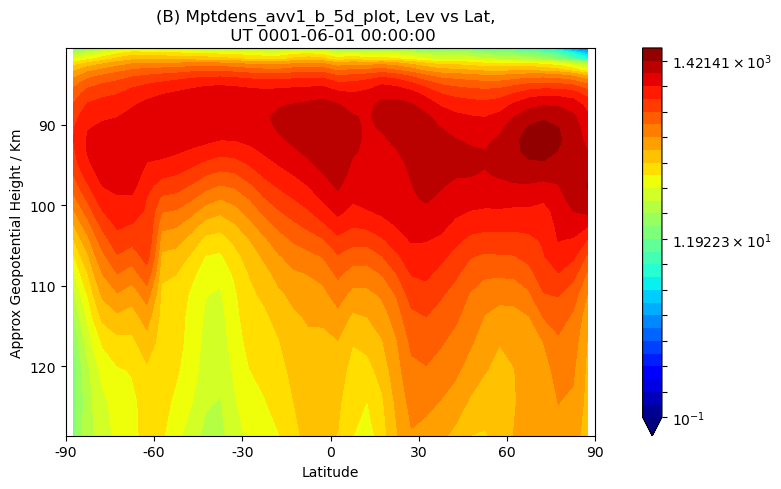

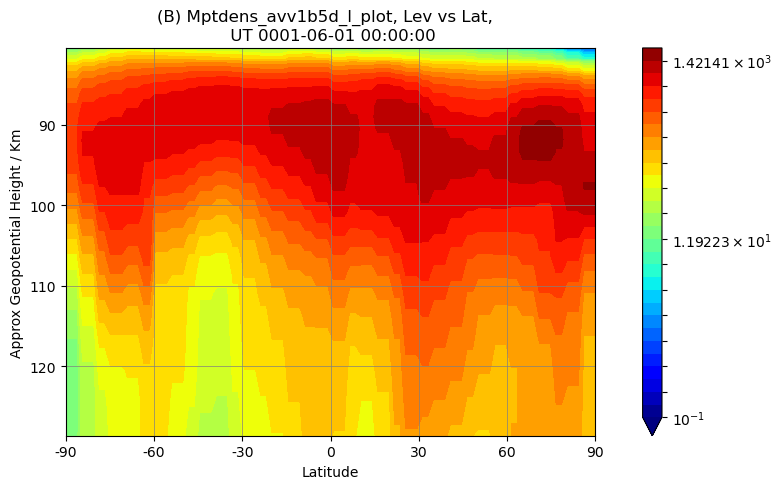

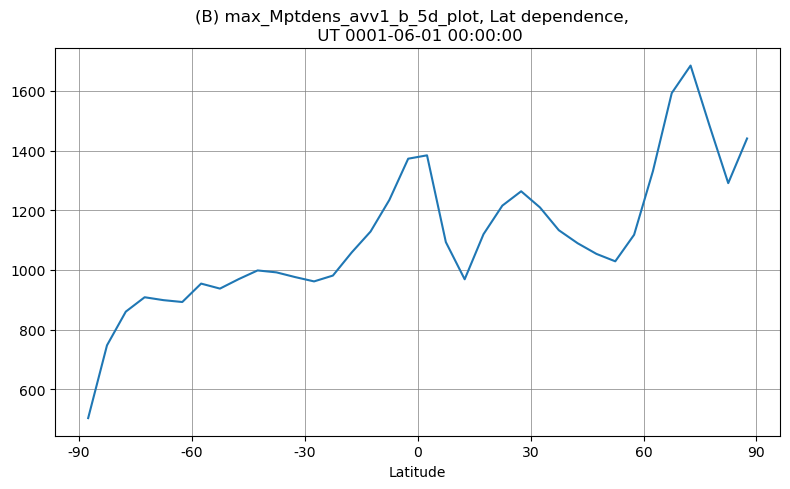

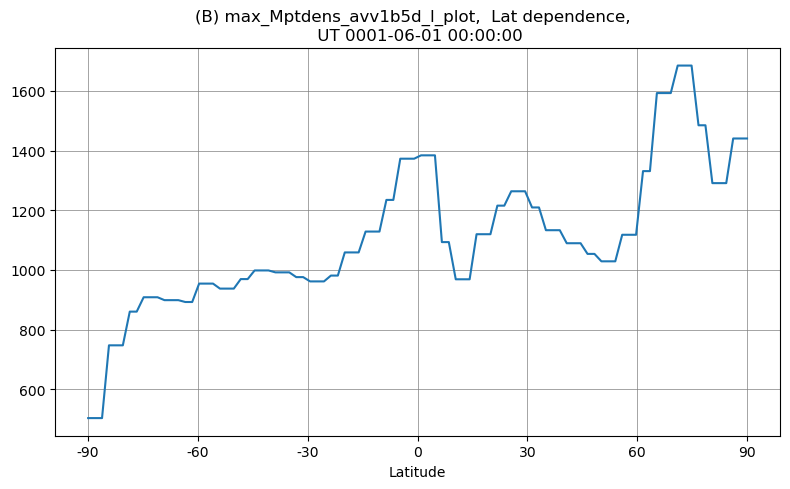

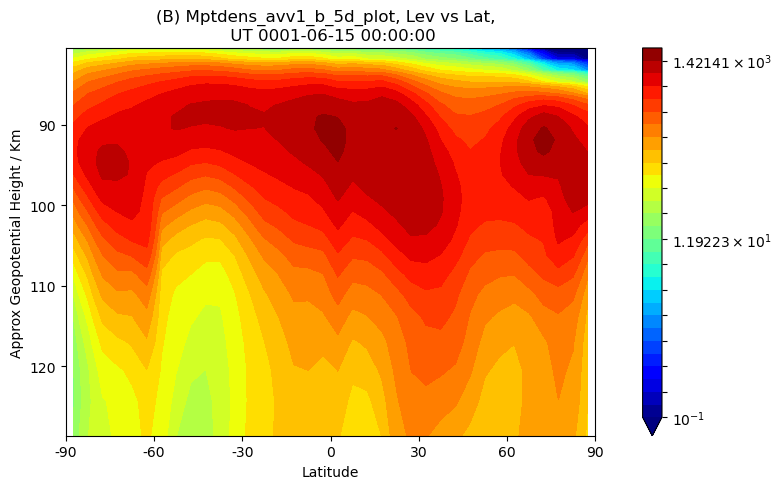

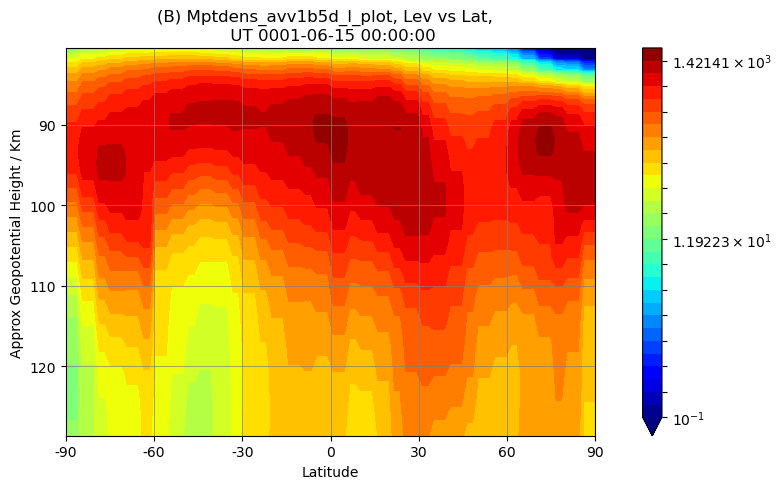

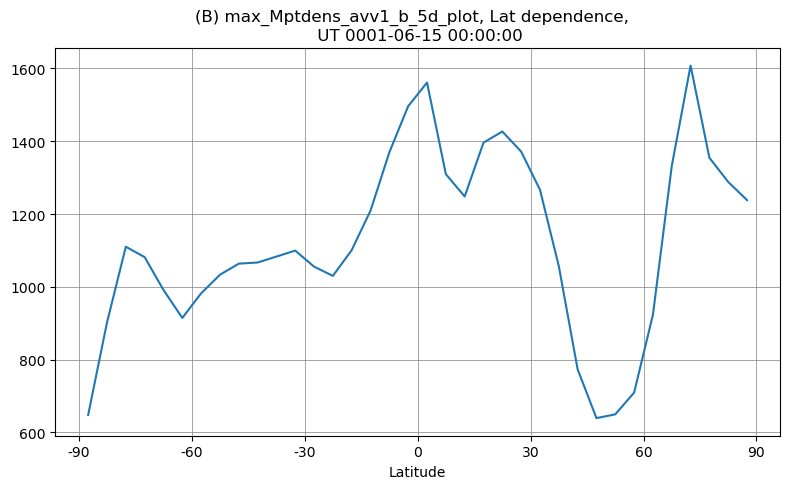

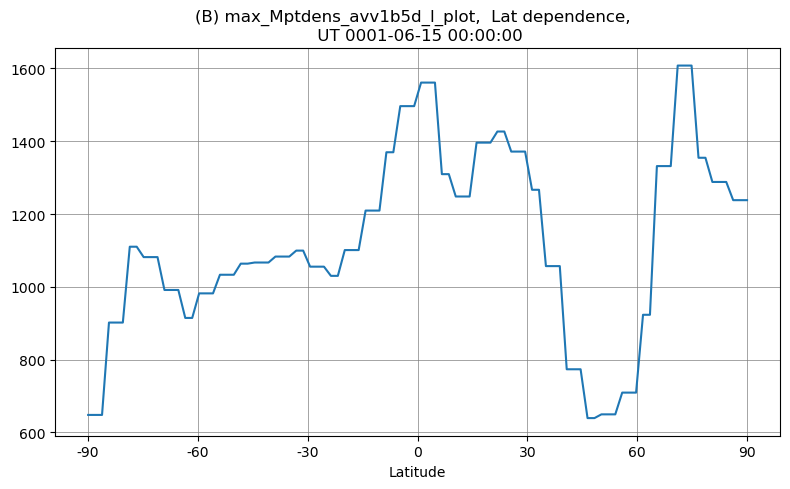

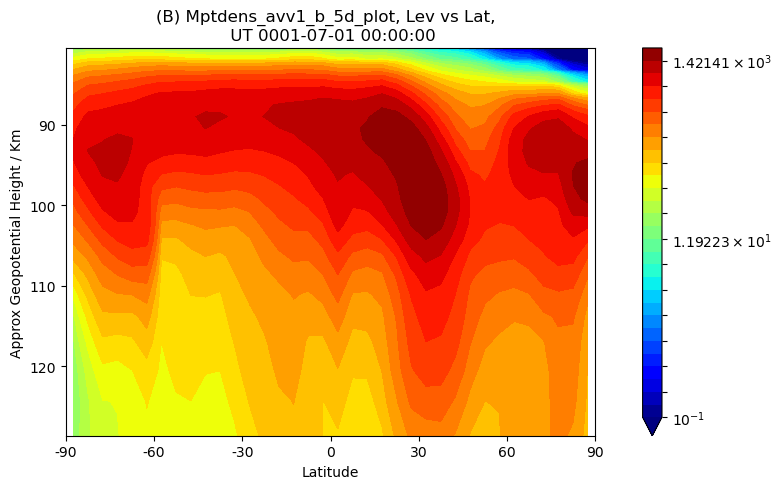

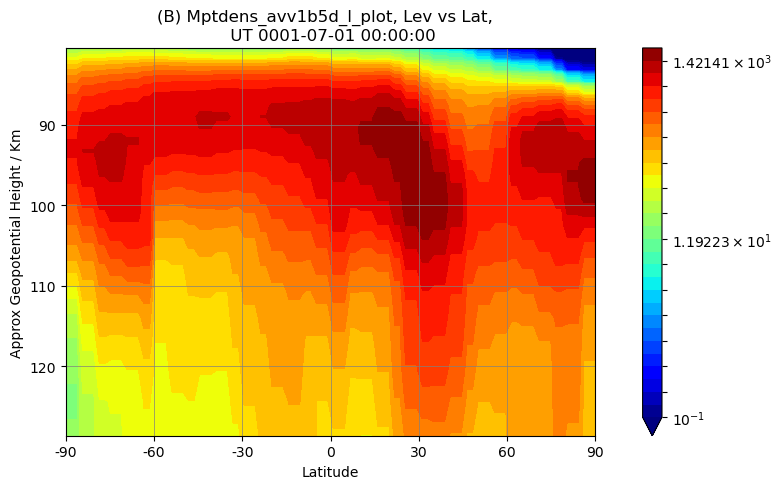

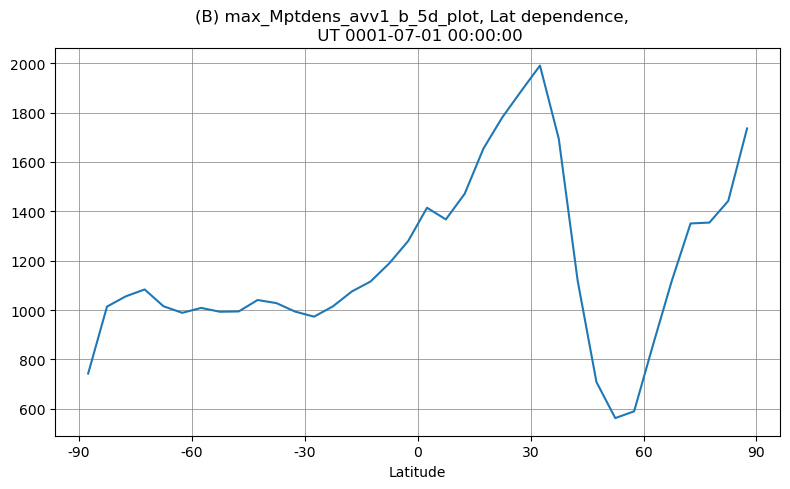

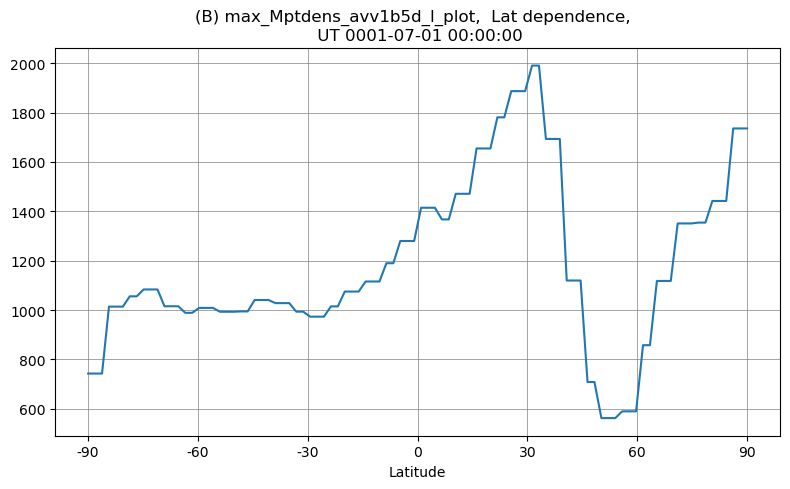

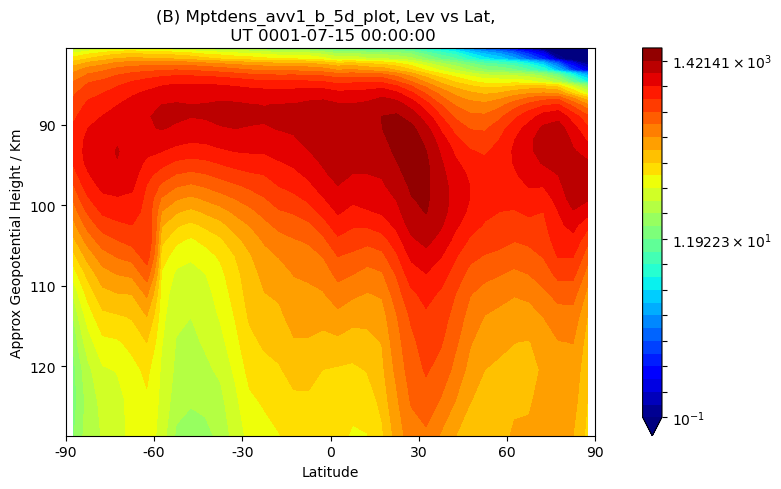

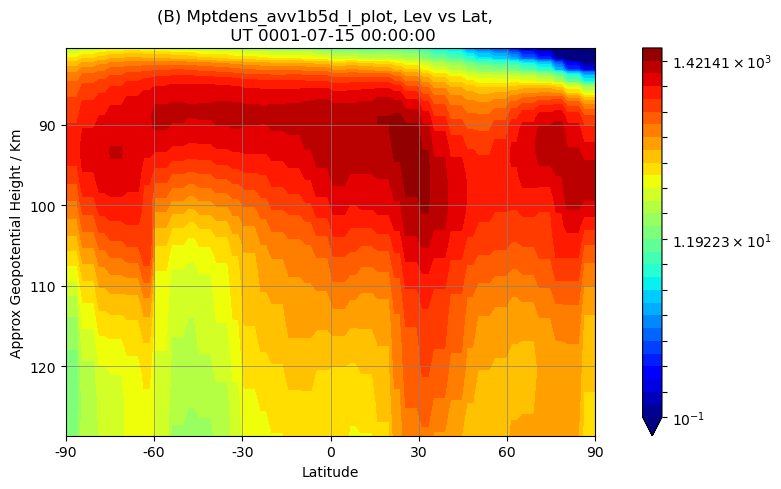

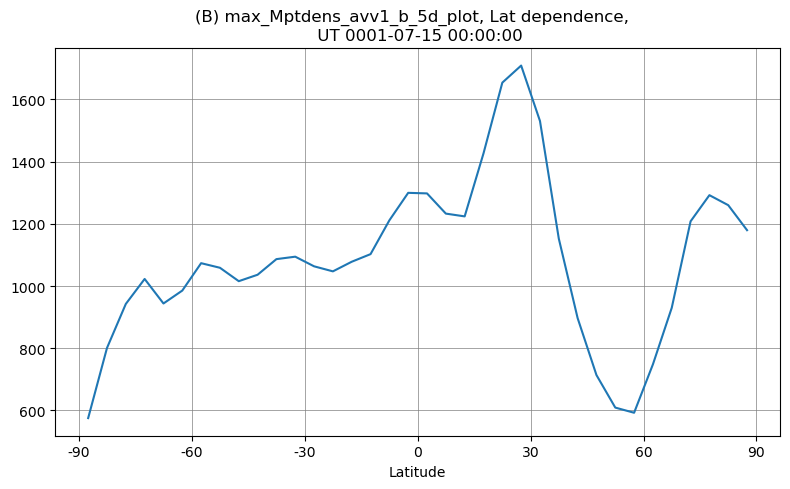

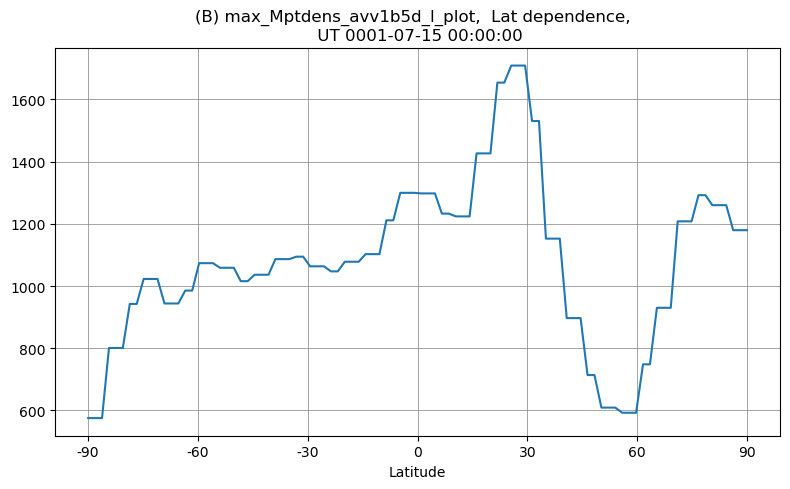

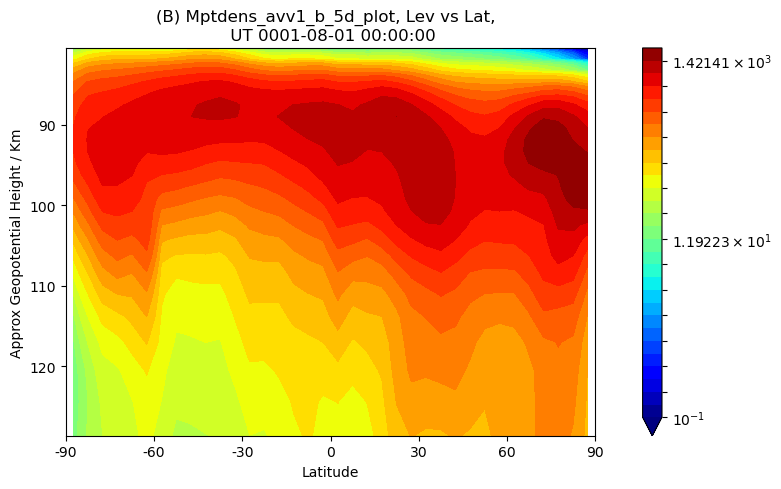

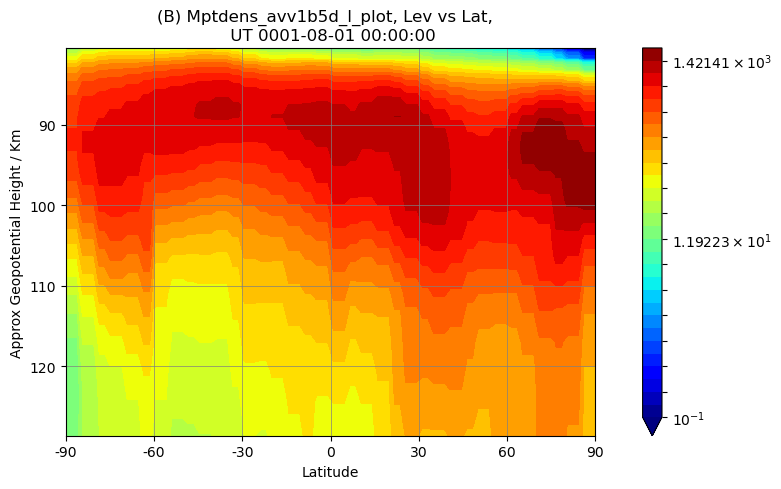

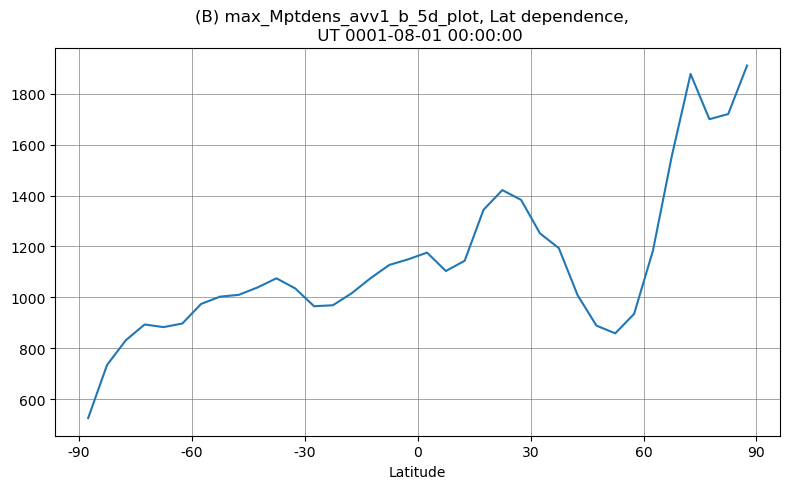

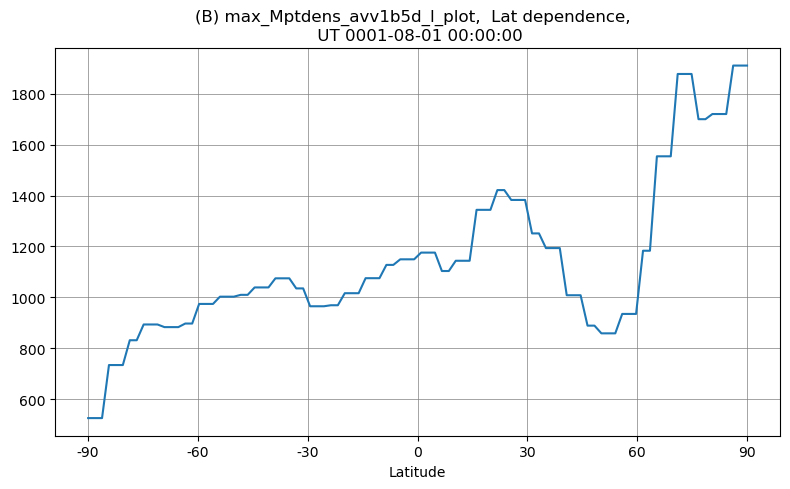

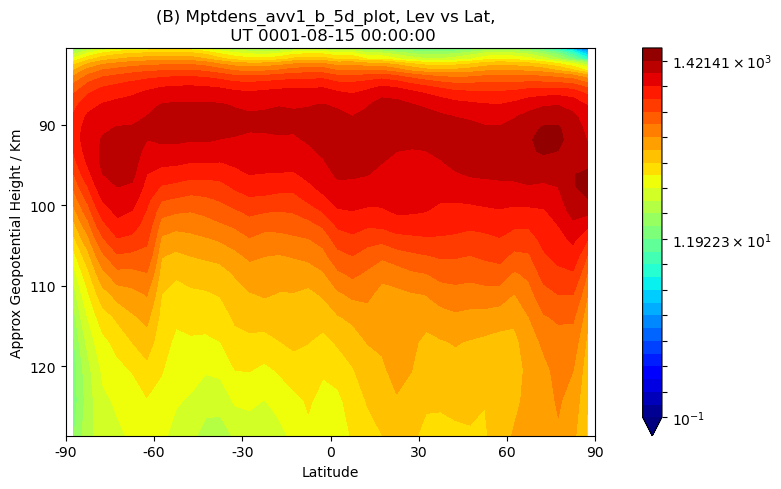

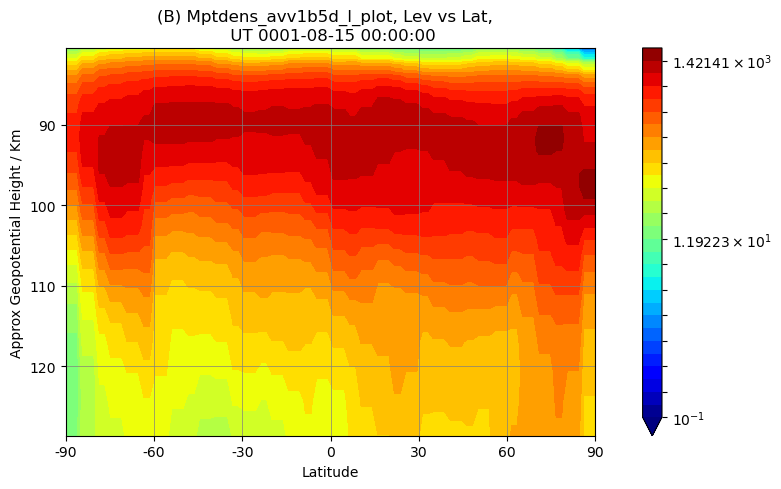

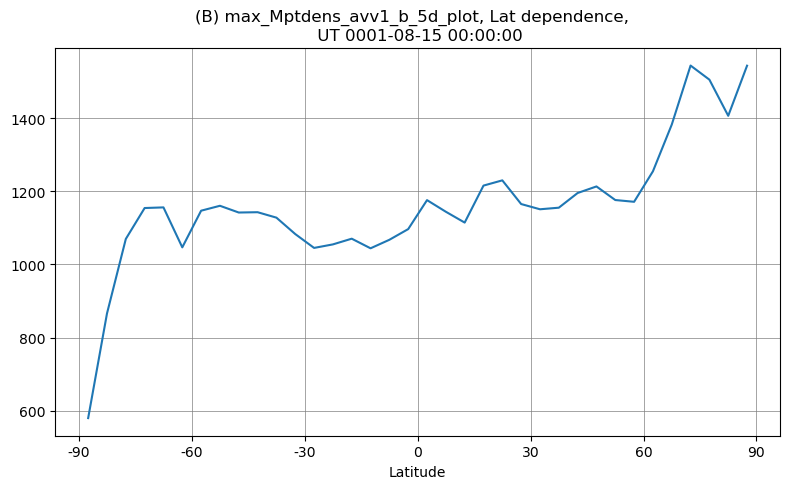

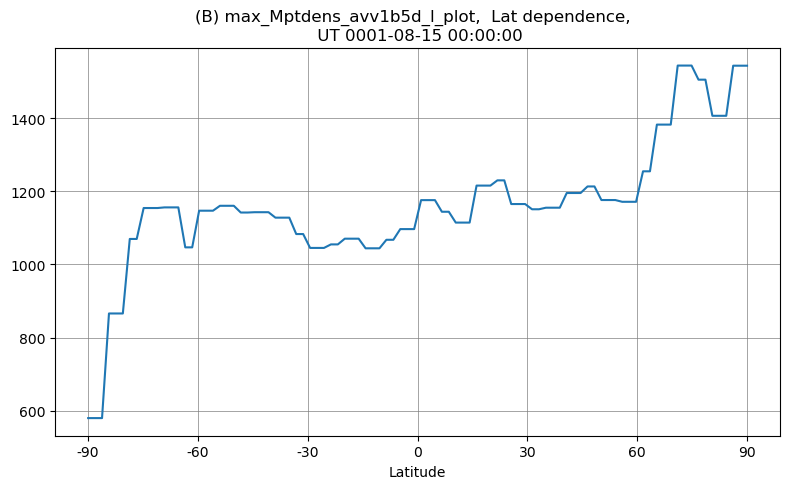

In [17]:
# Test plots for 5' lat-avg variables:

  #Average M+ density in 5' lat slices (as ft of lev), and the max over the lev dim
    #Mptdens_avv1_b_5d #lev_shape, intlat_shape, time_it_shape, ds_months_shape #5' slices     #Average M+ density in 5' lat slices (as ft of lev)
    #max_Mptdens_avv1_b_5d #lev_shape, intlat_shape, time_it_shape, ds_months_shape     #Max of Mptdens_avv1_b_5d over lev dim     
  
  #Variables below are the above 5' lat averages assigned to the correct index on a normal 96-long lat axis
    #Mptdens_avv1b5d_l #lev_shape, lat_shape, time_it_shape, ds_months_shape
    #max_Mptdens_avv1b5d_l #lat_shape, time_it_shape, ds_months_shape
#-----------------------------------------------------------


#-----------------------------------Lev-LT plot setup ----------------------------------------
lat_plot_idx = 74   #21=-50.2   #37 #=-19.9    
lat_plot = lat[lat_plot_idx]
lat_plot_str = str("%.1f" % lat_plot) 

#-----------------------------------
lev_sl_idx_plot_min = 0
lev_sl_idx_plot_max = 24
#print('      Plot Lev = ' + str("%.1e" % lev_sl[lev_sl_idx_plot_max]) + ' hPa' + ' : ' + str("%.1e" % lev_sl[lev_sl_idx_plot_min]) + ' hPa')
#print('      Approx Z = ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot_max]) + ' km' + ' : ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot_min]) + ' km')

Zavg_sl_plott = Zavg_sl[lev_sl_idx_plot_min:lev_sl_idx_plot_max+1]
Zavg_sl_plott = Zavg_sl_plott.to_numpy()
Zavg_sl_plottt = np.round_(Zavg_sl_plott, decimals=0)

Zavg_sl_plot_max = Zavg_sl_plott[0]
Zavg_sl_plot_min = Zavg_sl_plott[-1]

#-------------------Set up Local Time Ticks-------------------------------
timeconv = lon / 15
timeconv_plot = timeconv.to_numpy() 
timeconv_plot_ticks = np.arange(0,25, dtype=float)

#------------Set string values for sigma symbol to use in plot------------
sigma = '\u03C3'
#----------------------------------------


#levLTticks = np.linspace(0, 16, 17)

#-----------------------------------Lat-LT plot setup ----------------------------------------
# Set chosen/multiple levs to plot for lat-LT at a specific alt

lev_sl_idx_plot_multi = np.array([4],dtype=int)  #[ 4,  8, 14]
lev_sl_idx_plot_multi_shape = len(lev_sl_idx_plot_multi)  #3
lev_plot_ar = np.arange(0,lev_sl_idx_plot_multi_shape)   #[0,1,2]



for ids in ds_months_ar:   #iterate over month
    #--------------Set value for ids for plot variables-----------------------
    ids_plot = ids
    str_ids_plot = str(ids_plot)
    #print('Plot month ' + str_ids_plot + ': ' + str(ds_months[ids_plot]) )
    
    for it2 in time_ar_2wk:  #iterate over each 2wk sample period
            #--------------Set value for it2 for plot variables-----------------------
            it2_plot = it2
            str_it2_plot = str(it2_plot)
            #print('Plot time ' + str_it2_plot + ': ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] )
            #print('----------------------------------------')   
        
        
            #------------------------------------------------------------------
            #--------------------------------------------------------------------------------------------
            #---------------------------------------------------------------------

            Mptdens_avv1_b_5d_plot = Mptdens_avv1_b_5d[:,:,it2_plot,ids_plot]

            #-----------------------------------------------------
            ticks = np.geomspace(1*10**-1, 2*10**3, 30)


            fig, ax = plt.subplots(figsize=(8, 5))

            C = ax.contourf(intlat, Zavg_sl , Mptdens_avv1_b_5d_plot,   #lev_sl              
                             levels=ticks,
                             locator=ticker.LogLocator(),
                             extend='min',
                             cmap=jet)

            ax.set_xlabel('Latitude')
            ax.set_xticks(np.linspace(-90,90, 7)) 
            ax.set_xticklabels((-90,-60,-30,0,30,60,90)) 
        
            #ax.set_yscale('log')
            #ax.set_ylabel('Pressure / HPa')
            #ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 
            
            ax.set_ylabel('Approx Geopotential Height / Km')
            ax.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)

            ax.set_title(Crit_name +' '+ 'Mptdens_avv1_b_5d_plot, Lev vs Lat, ' + ' \n UT ' + times_str_min[ids_plot][it2_plot] ) 


            #ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            #plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

            #------------------
            def fmt(x, pos):
                a, b = '{:.1e}'.format(x).split('e')
                b = int(b)
                return r'${} \times 10^{{{}}}$'.format(a, b)

            cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            #-------------------

            #cbar.set_label(r'Density (cm$^{-3}$)')

            figname= Crit_name +' '+ 'Mptdens_avv1_b_5d_plot: Lat vs LT, ' + ' ' + times_str_min[ids_plot][it2_plot]  + '.png'


            plt.tight_layout()
            #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/5deg_latbins' + '/Lat-LT/'+str(figname), dpi = 400) #
            #---------------------------------------------------------------------------------------------------


            #--------------------------------------------------------------------
            #---------------------------------------------------------------------------------------------
            #---------------------------------------------------------------------

            Mptdens_avv1b5d_l_plot = Mptdens_avv1b5d_l[:,:,it2_plot,ids_plot]

            #-----------------------------------------------------
            ticks = np.geomspace(1*10**-1, 2*10**3, 30)


            fig, ax = plt.subplots(figsize=(8, 5))

            C = ax.contourf(lat, Zavg_sl, Mptdens_avv1b5d_l_plot,       #lev_sl          
                             levels=ticks,
                             locator=ticker.LogLocator(),
                             extend='min',
                             cmap=jet)

            ax.set_xlabel('Latitude')
            ax.set_xticks(np.linspace(-90,90, 7)) 
            ax.set_xticklabels((-90,-60,-30,0,30,60,90)) 
        
            #ax.set_yscale('log')
            #ax.set_ylabel('Pressure / HPa')
            #ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min)
            
            ax.set_ylabel('Approx Geopotential Height / Km')
            ax.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
    
            ax.set_title(Crit_name +' '+ 'Mptdens_avv1b5d_l_plot, Lev vs Lat, ' + ' \n UT ' + times_str_min[ids_plot][it2_plot]  ) 

            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

            #------------------
            def fmt(x, pos):
                a, b = '{:.1e}'.format(x).split('e')
                b = int(b)
                return r'${} \times 10^{{{}}}$'.format(a, b)

            cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            #-------------------

            #cbar.set_label(r'Density (cm$^{-3}$)')

            figname= Crit_name +' '+ 'Mptdens_avv1b5d_l_plot: Lat vs LT, ' + ' ' + times_str_min[ids_plot][it2_plot]  + '.png'


            plt.tight_layout()
            #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/5deg_latbins' + '/Lat-LT/'+str(figname), dpi = 400) #
            #---------------------------------------------------------------------------------------------------

            
            
            
            
            
            #------------------------------------------------------------------
            #--------------------------------------------------------------------------------------------
            #---------------------------------------------------------------------

            max_Mptdens_avv1_b_5d_plot = max_Mptdens_avv1_b_5d[:,it2_plot,ids_plot]

            #-----------------------------------------------------
            ticks = np.geomspace(1*10**-1, 2*10**3, 30)


            fig, ax = plt.subplots(figsize=(8, 5))

            
            C = ax.plot(intlat, max_Mptdens_avv1_b_5d_plot )
            
            ax.set_xlabel('Latitude')
            ax.set_xticks(np.linspace(-90,90, 7)) 
            ax.set_xticklabels((-90,-60,-30,0,30,60,90)) 


            ax.set_title(Crit_name +' '+ 'max_Mptdens_avv1_b_5d_plot, Lat dependence, ' + ' \n UT ' + times_str_min[ids_plot][it2_plot] ) 


            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)



            #cbar.set_label(r'Density (cm$^{-3}$)')

            figname= Crit_name +' '+ 'max_Mptdens_avv1_b_5d_plot: Lat, ' + ' ' + times_str_min[ids_plot][it2_plot]  + '.png'


            plt.tight_layout()
            #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/5deg_latbins' + '/Lat-LT/'+str(figname), dpi = 400) #
            #---------------------------------------------------------------------------------------------------



            #------------------------------------------------------------------
            #--------------------------------------------------------------------------------------------
            #---------------------------------------------------------------------

            max_Mptdens_avv1b5d_l_plot = max_Mptdens_avv1b5d_l[:,it2_plot,ids_plot]

            #-----------------------------------------------------
            ticks = np.geomspace(1*10**-1, 2*10**3, 30)


            fig, ax = plt.subplots(figsize=(8, 5))

            
            C = ax.plot(lat, max_Mptdens_avv1b5d_l_plot )
            
            ax.set_xlabel('Latitude')
            ax.set_xticks(np.linspace(-90,90, 7)) 
            ax.set_xticklabels((-90,-60,-30,0,30,60,90)) 


            ax.set_title(Crit_name +' '+ 'max_Mptdens_avv1b5d_l_plot,  Lat dependence, ' + ' \n UT ' + times_str_min[ids_plot][it2_plot] ) 


            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)



            #cbar.set_label(r'Density (cm$^{-3}$)')

            figname= Crit_name +' '+ 'max_Mptdens_avv1b5d_l: Lat, ' + ' ' + times_str_min[ids_plot][it2_plot]  + '.png'


            plt.tight_layout()
            #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/5deg_latbins' + '/Lat-LT/'+str(figname), dpi = 400) #
            #---------------------------------------------------------------------------------------------------




In [13]:
print(lev_plot_ar)

[0]


NameError: name 'lev_sl_plot_str' is not defined

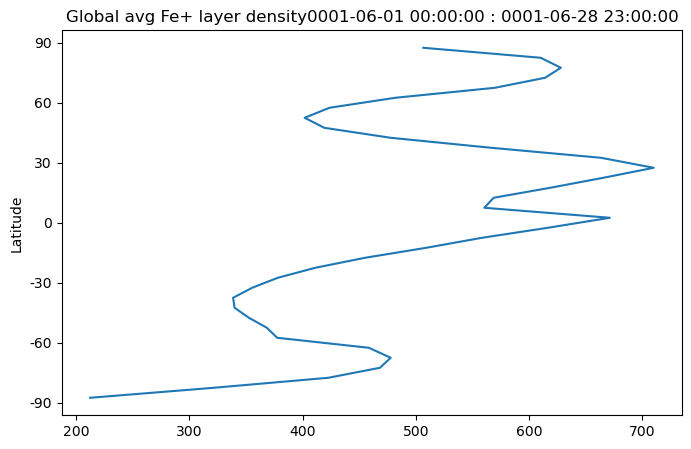

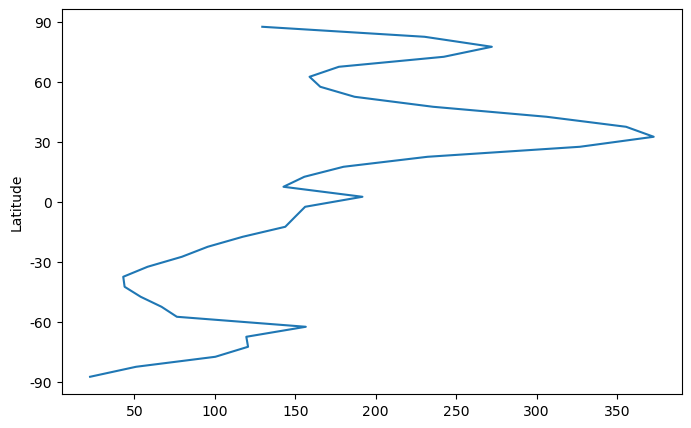

In [14]:
#Plots for testing purposes

    #Metal density in half hour LT bins and 5' lat slices - monthly and dataset avg
        #Mptdens_avg_bb_5d_avg_plot
        #Mptdens_avg_bb_5d_dsavg_plot
    

#===================================================================================================
start_time = time.process_time() 
#===================================================================================================

# Set chosen/multiple lat slices to plot

intlat_plot_idx_multi = np.array([24],dtype=int)    #[20,22,24,26,28],dtype=int) #+ve lats 10-15', 20-25' --> 50-55'       #[7,9,11,13,15],dtype=int) #-ve lats 10-15', 20-25' --> 50-55'     
intlat_plot_idx_multi_shape = len(intlat_plot_idx_multi)  
intlat_plot_ar = np.arange(0,intlat_plot_idx_multi_shape) 



#-----------------------------------Lev-LT plot setup ----------------------------------------
lat_plot_idx = 74   #21=-50.2   #37 #=-19.9    
lat_plot_str = str("%.1f" % lat[lat_plot_idx]) 

#-----------------------------------
lev_sl_idx_plot_min = 0
lev_sl_idx_plot_max = 24
#print('      Plot Lev = ' + str("%.1e" % lev_sl[lev_sl_idx_plot_max]) + ' hPa' + ' : ' + str("%.1e" % lev_sl[lev_sl_idx_plot_min]) + ' hPa')
#print('      Approx Z = ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot_max]) + ' km' + ' : ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot_min]) + ' km')

#Think this was used to set up tick labels but this is not being used any more
Zavg_sl_plott = Zavg_sl[lev_sl_idx_plot_min:lev_sl_idx_plot_max+1]
Zavg_sl_plott = Zavg_sl_plott.to_numpy()
Zavg_sl_plottt = np.round_(Zavg_sl_plott, decimals=0)

#-------------------Set up Local Time Ticks-------------------------------
timeconv = lon / 15
timeconv_plot = timeconv.to_numpy() 
timeconv_plot_ticks = np.arange(0,25, dtype=float)

#------------Set string values for sigma symbol to use in plot------------
sigma = '\u03C3'
#----------------------------------------


#levLTticks = np.linspace(0, 16, 17)



#-----------------------------------Lat-LT plot setup ----------------------------------------
# Set chosen/multiple levs to plot for lat-LT at a specific alt

lev_sl_idx_plot_multi = np.array([4],dtype=int)  #[ 4,  8, 14]
lev_sl_idx_plot_multi_shape = len(lev_sl_idx_plot_multi)  #3
lev_plot_ar = np.arange(0,lev_sl_idx_plot_multi_shape)   #[0,1,2]





for ids in ds_months_ar:   #iterate over month
    #--------------Set value for ids for plot variables-----------------------
    ids_plot = ids
    str_ids_plot = str(ids_plot)
    #print('Plot month ' + str_ids_plot + ': ' + str(ds_months[ids_plot]) )
      
        
        
    #-----------------------------------------------------
    #-----------------------global avg Fe+ layer ------------------------------
    #-----------------------------------------------------      
    Mptdens_avg_bb_5d_avg_plot_a = np.mean ( Mptdens_avg_bb_5d_avg[:,:,:,ids_plot], axis=2 ) #avg over lon
    #print(Mptdens_avg_bb_5d_avg_plot_a.shape)
    Mptdens_avg_bb_5d_avg_plot_avl = np.mean ( Mptdens_avg_bb_5d_avg_plot_a[:,:], axis=0 )  #avg over lev

    fig, ax = plt.subplots(figsize=(8, 5))
    C = ax.plot(Mptdens_avg_bb_5d_avg_plot_avl, intlat)
    ax.set_ylabel('Latitude')
    ax.set_yticks(np.linspace(-90,90, 7)) 
    ax.set_yticklabels((-90,-60,-30,0,30,60,90))
    ax.set_title('Global avg '+ Metal + '+ layer density' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1])
    #-----------------------------------------------------  
        
        
    #===================================================================================================================================================
    for iplev in lev_plot_ar:   #iterate over multiple levels for lat-LT plots at a specific alt
        #-----------------------------------Lat-LT plot setup ----------------------------------------
        #print('Lat-LT plot setup:')
        lev_sl_idx_plot = lev_sl_idx_plot_multi[iplev]    #14 4.9e-04hPa~95km  #8 1.1e-04hPa~105km  #4 4.0e-05 hPa~114km

        #print('      Plot Lev = ' + str("%.1e" % lev_sl[lev_sl_idx_plot]) + ' hPa' )
        #print('      Approx Z = ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot]) + ' km' )
        #===================================================================================================================================================

              
        
        #-----------------------------------------------------
        #---------------------------global avg Fe+ layer at plot lev --------------------------
        #-----------------------------------------------------
        Mptdens_avg_bb_5d_avg_plot_av = np.mean ( Mptdens_avg_bb_5d_avg[lev_sl_idx_plot,:,:,ids_plot], axis=1 )
        
        fig, ax = plt.subplots(figsize=(8, 5))
        C = ax.plot(Mptdens_avg_bb_5d_avg_plot_av, intlat)
        ax.set_ylabel('Latitude')
        ax.set_yticks(np.linspace(-90,90, 7)) 
        ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 
        ax.set_title('Global avg '+ Metal + '+ layer density at ' + lev_sl_plot_str + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1])
        #-----------------------------------------------------
        
        
        

        
        
        
        #----------------------Monthly avg (lev, lat, LT, ids)----------------------------------------------
        #-----------------------------------Lat-LT----------------------------------------------------------
        #------------------------data averaged in 5' lat slices---------------------------------------------

        Mptdens_avg_bb_5d_avg_plot = Mptdens_avg_bb_5d_avg[lev_sl_idx_plot,:,:,ids_plot]
        
        #-----------------------------------------------------
        ticks = np.geomspace(1*10**-1, 2*10**3, 30)


        fig, ax = plt.subplots(figsize=(8, 5))

        C = ax.contourf(timeconv_plot[::3], intlat, Mptdens_avg_bb_5d_avg_plot,                 
                         levels=ticks,
                         locator=ticker.LogLocator(),
                         #extend='min',
                         cmap=jet)

        ax.set_ylabel('Latitude')
        ax.set_yticks(np.linspace(-90,90, 7)) 
        ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

        ax.set_xlabel('Local Time / hrs')
        ax.set_xticks(np.linspace(0,24,13)) 
        ax.set_xticklabels(timeconv_plot_ticks[::2]) 

        if ds_months_shape>1:
            ax.set_title(Crit_name +' '+ 'Mptdens_avg_bb_5d_avg_plot, Lat vs LT, ' + ' \n UT ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] ) 
        else:
            ax.set_title(Crit_name +' '+ 'Mptdens_avg_bb_5d_avg_plot, Lat vs LT, ' + ' \n UT ' + times_str_min[0] + ' : ' + times_str_max[-1] ) 

        #ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
        #plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

        #------------------
        def fmt(x, pos):
            a, b = '{:.1e}'.format(x).split('e')
            b = int(b)
            return r'${} \times 10^{{{}}}$'.format(a, b)

        cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
        #-------------------

        cbar.set_label(r'Density (cm$^{-3}$)')

        if ds_months_shape>1:
            figname= Crit_name +' '+ 'Mptdens_avg_bb_5d_avg_plot: Lat vs LT, ' + ' ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] + '.png'
        else:
            figname= Crit_name +' '+ 'Mptdens_avg_bb_5d_avg_plot: Lat vs LT, ' + ' ' + times_str_min[0] + ' : ' + times_str_max[-1] + '.png'

        plt.tight_layout()
        #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/5deg_latbins' + '/Lat-LT/'+str(figname), dpi = 400) #
        #---------------------------------------------------------------------------------------------------

            
            
    for iintlatt in intlat_plot_ar:
        #print('Lev-LT plot setup (intlat):')
        intlat_plot_idx =  intlat_plot_idx_multi[iintlatt] 
        lat_plot_1 = intlat[intlat_plot_idx] -2.5
        lat_plot_2 = intlat[intlat_plot_idx] +2.5
        #print('      Plot lat = ' + str("%.0f" % lat_plot_1)  + ':' + str("%.0f" % lat_plot_2))
  
        
        
        #------------------------Monthly avg (lev, lat, LT, ids)--------------------------------------------
        #-----------------------------------Lev-LT----------------------------------------------------------
        #------------------------data averaged in 5' lat slices---------------------------------------------

        Mptdens_avg_bb_5d_avg_plot = Mptdens_avg_bb_5d_avg[:, intlat_plot_idx, :, ids_plot] 
        #-----------------------------------------------------

        ticks = np.geomspace(1*10**1, 5*10**3, 30)


        fig, ax = plt.subplots(figsize=(8, 5))

        C = ax.contourf(timeconv_plot[::3], Zavg_sl, Mptdens_avg_bb_5d_avg_plot,  #lev_sl
                         levels=ticks,
                         locator=ticker.LogLocator(),
                         extend='min',
                         cmap=jet)

        #ax.set_yscale('log')
        #ax.set_ylabel('Pressure / HPa')
        #ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 
        
        #ax2 = ax.twinx()
        #ax2.set_ylabel('Approx Geopotential Height / Km')
        #ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
        #ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])
        
        ax.set_ylabel('Approx Geopotential Height / Km')
        ax.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)

        
        ax.set_xlabel('Local Time / hrs')
        ax.set_xticks(np.linspace(0,24,13)) 
        ax.set_xticklabels(timeconv_plot_ticks[::2]) 
        
        if ds_months_shape>1:
            ax.set_title(Crit_name +' '+ 'Mptdens_avg_bb_5d_avg_plot, Lev vs LT, lat'  + lat_plot_str1 + ':' + lat_plot_str2 + ', \n UT ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] )
        else:
            ax.set_title(Crit_name +' '+ 'Mptdens_avg_bb_5d_avg_plot, Lev vs LT, lat'  + lat_plot_str1 + ':' + lat_plot_str2 + ', \n UT ' + times_str_min[0] + ' : ' + times_str_max[-1] )           
            
        ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
        #ax.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)
        plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

        #------------------
        def fmt(x, pos):
            a, b = '{:.1e}'.format(x).split('e')
            b = int(b)
            return r'${} \times 10^{{{}}}$'.format(a, b)

        cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
        #-------------------

        cbar.set_label(r'Density (cm$^{-3}$)')
        if ds_months_shape>1:
            figname= Crit_name +' '+ 'Mptdens_avg_bb_5d_avg_plot: Lev vs LT, lat'  + lat_plot_str1 + ':' + lat_plot_str2 + ' ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] + '.png'
        else:
            figname= Crit_name +' '+ 'Mptdens_avg_bb_5d_avg_plot: Lev vs LT, lat'  + lat_plot_str1 + ':' + lat_plot_str2 + ' ' + times_str_min[0] + ' : ' + times_str_max[-1] + '.png'

                         
        plt.tight_layout()
        #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/5deg_latbins'+ '/Lev-LT/'+str(figname), dpi = 400) #
        #---------------------------------------------------------------------------------------------------

        if ds_months_shape>1:
            #--------------------------Dataset avg (lev, lat, LT, ids)------------------------------------------
            #-----------------------------------Lev-LT----------------------------------------------------------
            #------------------------data averaged in 5' lat slices---------------------------------------------
            Mptdens_avg_bb_5d_dsavg_plot = Mptdens_avg_bb_5d_dsavg[:, intlat_plot_idx, :]

            #-----------------------------------------------------


            fig, ax = plt.subplots(figsize=(8, 5))

            C = ax.contourf(timeconv_plot[::3], Zavg_sl, Mptdens_avg_bb_5d_dsavg_plot,    #lev_sl
                             levels=ticks,
                             locator=ticker.LogLocator(),
                             extend='min',
                             cmap=jet)

            #ax.set_yscale('log')
            #ax.set_ylabel('Pressure / HPa')
            #ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

            #ax2 = ax.twinx()
            #ax2.set_ylabel('Approx Geopotential Height / Km')
            #ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
            #ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])

            ax.set_ylabel('Approx Geopotential Height / Km')
            ax.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)

            ax.set_xlabel('Local Time / hrs')
            ax.set_xticks(np.linspace(0,24,13)) 
            ax.set_xticklabels(timeconv_plot_ticks[::2]) 
            ax.set_title(Crit_name +' '+ 'Mptdens_avg_bb_5d_dsavg_plot, Lev vs LT, lat'  + lat_plot_str1 + ':' + lat_plot_str2 + ', \n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] )

            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            #ax.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)
            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

            #------------------
            def fmt(x, pos):
                a, b = '{:.1e}'.format(x).split('e')
                b = int(b)
                return r'${} \times 10^{{{}}}$'.format(a, b)

            cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            #-------------------

            cbar.set_label(r'Density (cm$^{-3}$)')

            figname= Crit_name +' '+ 'Mptdens_avg_bb_5d_dsavg_plot: Lev vs LT, lat'  + lat_plot_str1 + ':' + lat_plot_str2 + ' ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] + '.png'


            plt.tight_layout()
            #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr+ '/5deg_latbins' + '/Lev-LT/'+str(figname), dpi = 400) #
            #---------------------------------------------------------------------------------------------------


        
        
        #for it2 in time_ar_2wk:  #iterate over each 2wk sample period
        #    #--------------Set value for it2 for plot variables-----------------------
        #    it2_plot = it2
        #    str_it2_plot = str(it2_plot)
        #    #print('Plot time ' + str_it2_plot + ': ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] )
        #    #print('----------------------------------------')   
                
#===================================================================================================
end_time = time.process_time()
time_taken = end_time - start_time
time_taken_min = time_taken / 60.
print('========================================')
print('Calculation Time = ' + str(time_taken_min) + ' mins' ) 

In [ ]:
#Plots for testing purposes

#SpEs & Mptdens_sh



time_plot_idx = [0,6,12,18]
timearrr = np.arange(0,len(time_plot_idx), dtype=int)


#-----------------------------------Lev-LT plot setup ----------------------------------------
lat_plot_idx = 74   #21=-50.2   #37 #=-19.9    
lat_plot = lat[lat_plot_idx]
lat_plot_str = str("%.1f" % lat_plot) 
print('      Plot Lat = ' + lat_plot_str )
#-----------------------------------
lev_sl_idx_plot_min = 0
lev_sl_idx_plot_max = 24
print('      Plot Lev = ' + str("%.1e" % lev_sl[lev_sl_idx_plot_max]) + ' hPa' + ' : ' + str("%.1e" % lev_sl[lev_sl_idx_plot_min]) + ' hPa')
print('      Approx Z = ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot_max]) + ' km' + ' : ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot_min]) + ' km')

Zavg_sl_plott = Zavg_sl[lev_sl_idx_plot_min:lev_sl_idx_plot_max+1]
Zavg_sl_plott = Zavg_sl_plott.to_numpy()
Zavg_sl_plottt = np.round_(Zavg_sl_plott, decimals=0)

#-------------------Set up Local Time Ticks-------------------------------
timeconv = lon / 15
timeconv_plot = timeconv.to_numpy() 
timeconv_plot_ticks = np.arange(0,25, dtype=float)

#------------Set string values for sigma symbol to use in plot------------
sigma = '\u03C3'
#----------------------------------------



for ids in ds_months_ar:   #iterate over month
    
    start_cftime_date = '0001-' + str(ds_months[ids]) + '-01'
    times = xr.cftime_range(start=start_cftime_date, periods=672, freq="1H", calendar="noleap")    
    
   
    
    #--------------Set value for ids for plot variables-----------------------
    ids_plot = ids
    str_ids_plot = str(ids_plot)
    print('Plot month ' + str_ids_plot + ': ' + str(ds_months[ids_plot]) )
       
    
    for it2 in time_ar_2wk:  #iterate over each 2wk sample period
        
        #--------------Set value for it2 for plot variables-----------------------
        it2_plot = it2
        str_it2_plot = str(it2_plot)
     
        
        for itr in timearrr:  #
            if it2_plot == 0:
                plottime = times[ time_plot_idx[itr] ]
            else:
                plottime = times [ time_plot_idx[itr] + 336]
                print(plottime)
                
                
    
            
            #------------------------ SpEs_plot -----------------------------
            SpEs_plot = SpEs[:, itr , lat_plot_idx, :, it2_plot , ids_plot]
            
            
            #ticks = np.geomspace(1*10**2, 1*10**3, 30)
            ticks = np.linspace(1*10**2, 2*10**4, 30)

            fig, ax = plt.subplots(figsize=(8, 5))

            #C = ax.pcolormesh(timeconv_plot, lev_sl, SpEs_plot)
            C = ax.contourf(timeconv_plot, Zavg_sl, SpEs_plot,    #lev_sl
                             levels=ticks,
                             locator=ticker.LogLocator(),
                             extend='min',
                             cmap=jet)

            #ax.set_yscale('log')
            #ax.set_ylabel('Pressure / HPa')
            #ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

            #ax2 = ax.twinx()
            #ax2.set_ylabel('Approx Geopotential Height / Km')
            #ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
            #ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])

            ax.set_ylabel('Approx Geopotential Height / Km')
            ax.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
            
            ax.set_xlabel('Local Time / hrs')
            ax.set_xticks(np.linspace(0,24,13)) 
            ax.set_xticklabels(timeconv_plot_ticks[::2]) 

            ax.set_title(Crit_name +' '+ 'SpEs_plot, Lev vs LT, lat' + lat_plot_str + ',\n UT ' + str(plottime) ) #+ str(times[itr]) )

            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

            cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            #-------------------

            #cbar.set_label(r'Number of Occurences')

            figname= Crit_name +' '+ 'SpEs_plot: Lev vs LT, lat' + lat_plot_str + ' ' + str(plottime)  + '.png'
            plt.tight_layout()
            path = './Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Lev-LT/SpEs/'
            #plt.savefig(path+str(figname), dpi = 400) #
            
            
            
            
            
            
            
            #------------------------ Mptdens_sh[ilev,it,:,:,it2,ids] -----------------------------
            Mptdens_sh_plot = Mptdens_sh[:, itr , lat_plot_idx, :, it2_plot , ids_plot]
            
            
            #ticks = np.geomspace(1*10**2, 2*10**4, 30)

            fig, ax = plt.subplots(figsize=(8, 5))

            C = ax.contourf(timeconv_plot, Zavg_sl, Mptdens_sh_plot,   #lev_sl
                             levels=ticks,
                             locator=ticker.LogLocator(),
                             extend='min',
                             cmap=jet)

            #ax.set_yscale('log')
            #ax.set_ylabel('Pressure / HPa')
            #ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

            #ax2 = ax.twinx()
            #ax2.set_ylabel('Approx Geopotential Height / Km')
            #ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
            #ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])

            ax.set_ylabel('Approx Geopotential Height / Km')
            ax.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
            
            ax.set_xlabel('Local Time / hrs')
            ax.set_xticks(np.linspace(0,24,13)) 
            ax.set_xticklabels(timeconv_plot_ticks[::2]) 

            ax.set_title(Crit_name +' '+ 'Mptdens_sh_plot, Lev vs LT, lat' + lat_plot_str + ',\n UT ' + str(plottime) ) #+ str(times[itr]) )

            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

            cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            #-------------------

            #cbar.set_label(r'Number of Occurences')

            figname= Crit_name +' '+ 'Mptdens_sh_plot: Lev vs LT, lat' + lat_plot_str + ' ' + str(plottime)  + '.png'
            plt.tight_layout()
            path = './Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Lev-LT/SpEs/'
            #plt.savefig(path+str(figname), dpi = 400) #



In [ ]:
#Critical frequency plots:
    #SpEs_e          #The e density where SpEs have been identified using Fe+ density       
    #edens_sh        #e density in local time
    
    #maxSpEs__e      #max of SpEs_e in cm-3
    #foEs_m          #Critical freq (calculated using max e- density over lev dim in m-3)
    #foEs_m_av       #Avg of foEs_m over lev dimension
    #foEs_m_av_mth   #Average of foEs_m_av over month
    #foEs_m_av_ds    #AVerage of foEs_m_av_mth over dataset (e.g. 3mth)


time_plot_idx = [12]#,6]#,12,18]
timearrr = np.arange(0,len(time_plot_idx), dtype=int)


#-----------------------------------Lev-LT plot setup ----------------------------------------
lat_plot_idx = 74   #21=-50.2   #37 #=-19.9    
print('      Plot Lat = ' + str("%.1f" % lat[lat_plot_idx])  )
#-----------------------------------
lev_sl_idx_plot_min = 0
lev_sl_idx_plot_max = 24
print('      Plot Lev = ' + str("%.1e" % lev_sl[lev_sl_idx_plot_max]) + ' hPa' + ' : ' + str("%.1e" % lev_sl[lev_sl_idx_plot_min]) + ' hPa')
print('      Approx Z = ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot_max]) + ' km' + ' : ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot_min]) + ' km')

Zavg_sl_plott = Zavg_sl[lev_sl_idx_plot_min:lev_sl_idx_plot_max+1]
Zavg_sl_plott = Zavg_sl_plott.to_numpy()
Zavg_sl_plottt = np.round_(Zavg_sl_plott, decimals=0)

#-------------------Set up Local Time Ticks-------------------------------
timeconv = lon / 15
timeconv_plot = timeconv.to_numpy() 
timeconv_plot_ticks = np.arange(0,25, dtype=float)

#------------Set string values for sigma symbol to use in plot------------
sigma = '\u03C3'
#----------------------------------------


#------------------------ foEs_m_av_ds -----------------------------
#------------------------ Lat-LT -----------------------------

ticks = np.linspace(0, 5, 21)

fig, ax = plt.subplots(figsize=(8, 5))

C = ax.contourf(timeconv_plot, lat, foEs_m_av_ds,
                 levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.set_ylabel('Latitude')
ax.set_yticks(np.linspace(-90,90, 7)) 
ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title(Crit_name +' '+ 'foEs_m_av_ds, Lat vs LT ' + ',\n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] ) #+ str(times[itr]) )

ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'Critical Frequency / MHz')

figname= Crit_name +' '+ 'foEs_m_av_ds: Lat vs LT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1]  + '.png'
plt.tight_layout()
path = './Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Lat-LT/SpEs/'
plt.savefig(path+str(figname), dpi = 400) #
#-------------------------------------------------------------------




for ids in ds_months_ar:   #iterate over month
    
    start_cftime_date = '0001-' + str(ds_months[ids]) + '-01'
    times = xr.cftime_range(start=start_cftime_date, periods=672, freq="1H", calendar="noleap")    
    
   
    
    #--------------Set value for ids for plot variables-----------------------
    ids_plot = ids
    str_ids_plot = str(ids_plot)
    print('Plot month ' + str_ids_plot + ': ' + str(ds_months[ids_plot]) )
    

    
    #------------------------ foEs_m_av_mth_plot -----------------------------
    #------------------------ Lat-LT -----------------------------
    foEs_m_av_mth_plot = foEs_m_av_mth[:, : , ids_plot]

    ticks = np.linspace(0, 5, 21)

    fig, ax = plt.subplots(figsize=(8, 5))

    C = ax.contourf(timeconv_plot, lat, foEs_m_av_mth_plot,
                     levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    ax.set_ylabel('Latitude')
    ax.set_yticks(np.linspace(-90,90, 7)) 
    ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title(Crit_name +' '+ 'foEs_m_av_mth_plot, Lat vs LT ' + ',\n UT ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] ) #+ str(times[itr]) )

    ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r'Critical Frequency / MHz')

    figname= Crit_name +' '+ 'foEs_m_av_mth_plot: Lat vs LT ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1]  + '.png'
    plt.tight_layout()
    path = './Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Lat-LT/SpEs/'
    #plt.savefig(path+str(figname), dpi = 400) #
    #-------------------------------------------------------------------
        
        
    
    for it2 in time_ar_2wk:  #iterate over each 2wk sample period
        
        #--------------Set value for it2 for plot variables-----------------------
        it2_plot = it2
        str_it2_plot = str(it2_plot)
     


        #------------------------ foEs_m_av_plot -----------------------------
        #------------------------ Lat-LT -----------------------------
        foEs_m_av_plot = foEs_m_av[:, :, it2_plot , ids_plot]

        ticks = np.linspace(0, 5, 21)

        fig, ax = plt.subplots(figsize=(8, 5))

        C = ax.contourf(timeconv_plot, lat, foEs_m_av_plot,
                         levels=ticks,
                         #locator=ticker.LogLocator(),
                         #extend='min',
                         cmap=jet)

        ax.set_ylabel('Latitude')
        ax.set_yticks(np.linspace(-90,90, 7)) 
        ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

        ax.set_xlabel('Local Time / hrs')
        ax.set_xticks(np.linspace(0,24,13)) 
        ax.set_xticklabels(timeconv_plot_ticks[::2]) 

        ax.set_title(Crit_name +' '+ 'foEs_m_av_plot, Lat vs LT ' + ',\n UT ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] ) #+ str(times[itr]) )

        ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
        plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

        cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
        #-------------------

        cbar.set_label(r'Critical Frequency / MHz')

        figname= Crit_name +' '+ 'foEs_m_av_plot: Lat vs LT ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot]  + '.png'
        plt.tight_layout()
        path = './Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Lat-LT/SpEs/'
        #plt.savefig(path+str(figname), dpi = 400) #
        #-------------------------------------------------------------------
        
        
        
        
        for itr in timearrr:  #iterate over chosen timesteps for plotting
            if it2_plot == 0:
                plottime = times[ time_plot_idx[itr] ]
            else:
                plottime = times [ time_plot_idx[itr] + 336]
                print(plottime)
                

            #------------------------ maxSpEs_e_plot -----------------------------
            #------------------------ Lat-LT -----------------------------
            maxSpEs__e_plot = maxSpEs__e[itr , :, :, it2_plot , ids_plot]
            
            ticks = np.geomspace(1*10**3, 2*10**5, 30)
            #ticks = np.geomspace(1*10**9, 1*10**12, 30)
            
            fig, ax = plt.subplots(figsize=(8, 5))

            C = ax.contourf(timeconv_plot, lat, maxSpEs__e_plot,
                             levels=ticks,
                             locator=ticker.LogLocator(),
                             #extend='min',
                             cmap=jet)

            ax.set_ylabel('Latitude')
            ax.set_yticks(np.linspace(-90,90, 7)) 
            ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 
        
            ax.set_xlabel('Local Time / hrs')
            ax.set_xticks(np.linspace(0,24,13)) 
            ax.set_xticklabels(timeconv_plot_ticks[::2]) 

            ax.set_title(Crit_name +' '+ 'maxSpEs__e_plot, Lat vs LT ' + ',\n UT ' + str(plottime) ) #+ str(times[itr]) )

            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)
            
            #------------------
            def fmt(x, pos):
                a, b = '{:.1e}'.format(x).split('e')
                b = int(b)
                return r'${} \times 10^{{{}}}$'.format(a, b)
        
            cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            #-------------------

            cbar.set_label(r'cm$^{-3}$')

            figname= Crit_name +' '+ 'maxSpEs__e_plot: Lat vs LT ' + str(plottime)  + '.png'
            plt.tight_layout()
            path = './Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Lat-LT/SpEs/'
            #plt.savefig(path+str(figname), dpi = 400) #
            #-------------------------------------------------------------------
            
            

            #------------------------ foEs_m_plot -----------------------------
            #------------------------ Lat-LT -----------------------------
            foEs_m_plot = foEs_m[itr , :, :, it2_plot , ids_plot]
            
            ticks = np.linspace(0, 5, 21)

            fig, ax = plt.subplots(figsize=(8, 5))

            C = ax.contourf(timeconv_plot, lat, foEs_m_plot,
                             levels=ticks,
                             #locator=ticker.LogLocator(),
                             #extend='min',
                             cmap=jet)

            ax.set_ylabel('Latitude')
            ax.set_yticks(np.linspace(-90,90, 7)) 
            ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 
        
            ax.set_xlabel('Local Time / hrs')
            ax.set_xticks(np.linspace(0,24,13)) 
            ax.set_xticklabels(timeconv_plot_ticks[::2]) 

            ax.set_title(Crit_name +' '+ 'foEs_m_plot, Lat vs LT ' + ',\n UT ' + str(plottime) ) #+ str(times[itr]) )

            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

            cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            #-------------------

            cbar.set_label(r'Critical Frequency / MHz')

            figname= Crit_name +' '+ 'foEs_m_plot: Lat vs LT ' + str(plottime)  + '.png'
            plt.tight_layout()
            path = './Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Lat-LT/SpEs/'
            #plt.savefig(path+str(figname), dpi = 400) #
            #-------------------------------------------------------------------
        
        
        
        

            #------------------------ SpEs_e_plot -----------------------------
            SpEs_e_plot = SpEs_e[:, itr , lat_plot_idx, :, it2_plot , ids_plot]
            
            ticks = np.geomspace(1*10**2, 2*10**5, 30)
            #ticks = np.linspace(1*10**2, 2*10**4, 30)

            fig, ax = plt.subplots(figsize=(8, 5))

            #C = ax.pcolormesh(timeconv_plot, lev_sl, SpEs_plot)
            C = ax.contourf(timeconv_plot, Zavg_sl, SpEs_e_plot,   #lev_sl
                             levels=ticks,
                             locator=ticker.LogLocator(),
                             #extend='min',
                             cmap=jet)

            #ax.set_yscale('log')
            #ax.set_ylabel('Pressure / HPa')
            #ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

            #ax2 = ax.twinx()
            #ax2.set_ylabel('Approx Geopotential Height / Km')
            #ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
            #ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])

            ax.set_ylabel('Approx Geopotential Height / Km')
            ax.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
            
            ax.set_xlabel('Local Time / hrs')
            ax.set_xticks(np.linspace(0,24,13)) 
            ax.set_xticklabels(timeconv_plot_ticks[::2]) 

            ax.set_title(Crit_name +' '+ 'SpEs_e_plot, Lev vs LT, lat' + lat_plot_str + ',\n UT ' + str(plottime) ) #+ str(times[itr]) )

            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)
    
            cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            #-------------------

            #cbar.set_label(r'Number of Occurences')

            figname= Crit_name +' '+ 'SpEs_e_plot: Lev vs LT, lat' + lat_plot_str + ' ' + str(plottime)  + '.png'
            plt.tight_layout()
            path = './Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Lev-LT/SpEs/'
            #plt.savefig(path+str(figname), dpi = 400) #
            #-------------------------------------------------------------------
            
            
            
            
            
            #------------------------ edens_sh[ilev,it,:,:,it2,ids] -----------------------------
            edens_sh_plot = edens_sh[:, itr , lat_plot_idx, :, it2_plot , ids_plot]
            
            
            ticks = np.geomspace(1*10**2, 2*10**5, 30)
            #ticks = np.linspace(1*10**2, 2*10**4, 30)

            fig, ax = plt.subplots(figsize=(8, 5))

            C = ax.contourf(timeconv_plot, Zavg_sl, edens_sh_plot,   #lev_sl
                             levels=ticks,
                             locator=ticker.LogLocator(),
                             extend='min',
                             cmap=jet)

            #ax.set_yscale('log')
            #ax.set_ylabel('Pressure / HPa')
            #ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

            #ax2 = ax.twinx()
            #ax2.set_ylabel('Approx Geopotential Height / Km')
            #ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
            #ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])

            ax.set_ylabel('Approx Geopotential Height / Km')
            ax.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
            
            ax.set_xlabel('Local Time / hrs')
            ax.set_xticks(np.linspace(0,24,13)) 
            ax.set_xticklabels(timeconv_plot_ticks[::2]) 

            ax.set_title(Crit_name +' '+ 'edens_sh_plot, Lev vs LT, lat' + lat_plot_str + ',\n UT ' + str(plottime) ) #+ str(times[itr]) )

            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

            cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            #-------------------

            #cbar.set_label(r'Number of Occurences')

            figname= Crit_name +' '+ 'edens_sh_plot: Lev vs LT, lat' + lat_plot_str + ' ' + str(plottime)  + '.png'
            plt.tight_layout()
            path = './Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Lev-LT/SpEs/'
            #plt.savefig(path+str(figname), dpi = 400) #
            #-------------------------------------------------------------------




In [ ]:
#Occ freq (lat, LT) averaged over LT -> Occ freq as fct of lat only

SpEs_Occ_Fr_b_dsavglevLT = np.mean(SpEs_Occ_Fr_b_dsavglev, axis=1)
SpEs_Occ_Fr_b_dsavglevLT.shape

In [ ]:
#SpEs Occ Freq plots - all
#Main bulk of plots for comparison with COSMIC data

#===================================================================================================
start_time = time.process_time() 
#===================================================================================================

# Set chosen/multiple lat slices to plot

intlat_plot_idx_multi = np.array([20,22,24,26,28],dtype=int) #+ve lats 10-15', 20-25' --> 50-55'       #[7,9,11,13,15],dtype=int) #-ve lats 10-15', 20-25' --> 50-55'     
intlat_plot_idx_multi_shape = len(intlat_plot_idx_multi)  
intlat_plot_ar = np.arange(0,intlat_plot_idx_multi_shape) 


# Set chosen/multiple levs to plot for lat-LT at a specific alt

lev_sl_idx_plot_multi = np.array([4,8,14],dtype=int)  #[ 4,  8, 14]
lev_sl_idx_plot_multi_shape = len(lev_sl_idx_plot_multi)  #3
lev_plot_ar = np.arange(0,lev_sl_idx_plot_multi_shape)   #[0,1,2]


#-----------------------------------Lev-LT plot setup ----------------------------------------
lat_plot_idx = 74   #21=-50.2   #37 #=-19.9    
lat_plot_str = str("%.1f" % lat[lat_plot_idx]) 

#-----------------------------------
lev_sl_idx_plot_min = 0
lev_sl_idx_plot_max = 24
#print('      Plot Lev = ' + str("%.1e" % lev_sl[lev_sl_idx_plot_max]) + ' hPa' + ' : ' + str("%.1e" % lev_sl[lev_sl_idx_plot_min]) + ' hPa')
#print('      Approx Z = ' + str("%.0f" % Zavg_sl[lev_sl_idx_plot_max]) + ' km' + ' : ' + str("%.0f" %  Zavg_sl[lev_sl_idx_plot_min]) + ' km')

Zavg_sl_plott = Zavg_sl[lev_sl_idx_plot_min:lev_sl_idx_plot_max+1]
Zavg_sl_plott = Zavg_sl_plott.to_numpy()
Zavg_sl_plottt = np.round_(Zavg_sl_plott, decimals=0)

#-------------------Set up Local Time Ticks-------------------------------
timeconv = lon / 15
timeconv_plot = timeconv.to_numpy() 
timeconv_plot_ticks = np.arange(0,25, dtype=float)

#------------Set string values for sigma symbol to use in plot------------
sigma = '\u03C3'
#----------------------------------------


levLTticks = np.linspace(0, 16, 17)

if ds_months_shape>1:
    #--------------------------Dataset avg (lev, lat, LT, ids)------------------------------------------
    #-----------------------------------Lev-LT----------------------------------------------------------
    #---------------------------------------------------------------------------------------------------

    SpEs_Occ_Fr_b_dsavg_plot = SpEs_Occ_Fr_b_dsavg[:,lat_plot_idx,:] 

    #-----------------------------------------------------
    #ticks = np.linspace(0, 14, 15)
    ticks = levLTticks
    #ticks = np.linspace(0, 40, 21) #(F)

    fig, ax = plt.subplots(figsize=(8, 5))

    C = ax.contourf(timeconv_plot[::3], Zavg_sl, SpEs_Occ_Fr_b_dsavg_plot, #lev_sl
                     levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    #ax.set_yscale('log')
    #ax.set_ylabel('Pressure / HPa')
    #ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

    #ax2 = ax.twinx()
    #ax2.set_ylabel('Approx Geopotential Height / Km')
    #ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
    #ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])

    ax.set_ylabel('Approx Geopotential Height / Km')
    ax.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
    

    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_dsavg_plot, Lev vs LT, lat' + lat_plot_str + ', \n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] )

    ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    #ax.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)
    plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r'%')

    figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_dsavg_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] + '.png'
    plt.tight_layout()
    #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Criteria_5deglats/Lev-LT/'+str(figname), dpi = 400) #
    #---------------------------------------------------------------------------------------------------


    
    #--------------------Dataset avg over all heights (Lat)-----------------------------------------
    #---------------------------------------------------------------------------------------------
    
    
    ticks = np.linspace(0, 8, 17)

    fig, ax = plt.subplots(figsize=(8, 5))

    C = ax.plot(SpEs_Occ_Fr_b_dsavglevLT, lat)

    ax.set_ylabel('Latitude')
    ax.set_yticks(np.linspace(-90,90, 7)) 
    ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

    ax.set_xlabel('SpE Occ Frequency / %')
    #ax.set_xticks(np.linspace(0,24,13)) 
    #ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_dsavglevLT, ' + ' \n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] )

    #ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    #plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_dsavglevLT: Lat, ' + ' ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] + '.png'
    plt.tight_layout()
    #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Criteria_5deglats/Lat-LT/'+str(figname), dpi = 400) #

    #--------------------------------------------------------------------------------------------------- 
    
    
    
    
    

    #--------------------Dataset avg over all heights (lat, LT)-----------------------------------------
    #-----------------------------------Lat-LT----------------------------------------------------------
    #---------------------------------------------------------------------------------------------------


    ticks = np.linspace(0, 8, 17)

    fig, ax = plt.subplots(figsize=(8, 5))

    C = ax.contourf(timeconv_plot[::3], lat, SpEs_Occ_Fr_b_dsavglev, 
                     levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    ax.set_ylabel('Latitude')
    ax.set_yticks(np.linspace(-90,90, 7)) 
    ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_dsavglev, Lat vs LT, ' + ' \n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] )

    #ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    #plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r'%')

    figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_dsavglev: Lat vs LT, ' + ' ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] + '.png'
    plt.tight_layout()
    #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Criteria_5deglats/Lat-LT/'+str(figname), dpi = 400) #

    #--------------------------------------------------------------------------------------------------- 
    
    
    

    #--------------------Dataset avg over all heights (lat, LT)-----------------------------------------
    #-----------------------------------Lat-LT----------------------------------------------------------
    #------------------------data averaged in 5' lat slices---------------------------------------------

    SpEs_Occ_Fr_bb_5d_dsavglev_plot = SpEs_Occ_Fr_bb_5d_dsavglev[:,:]  #Whole Dataset avg over all heights ->(36, 48) lat,LT

    #-----------------------------------------------------

    #ticks = np.linspace(0, 8, 17)
    #ticks = np.linspace(0, 40, 21) #(F)

    fig, ax = plt.subplots(figsize=(8, 5))

    C = ax.contourf(timeconv_plot[::3], intlat, SpEs_Occ_Fr_bb_5d_dsavglev_plot,

                     #levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    ax.set_ylabel('Latitude')
    ax.set_yticks(np.linspace(-90,90, 7)) 
    ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_dsavglev_plot, Lat vs LT, ' + ' \n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] ) 

    #ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    #plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.07)#,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r'%')

    figname= Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_dsavglev_plot: Lat vs LT, ' + ' ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] + '.png'


    plt.tight_layout()
    #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr+ '/Criteria_5deglats/5deg_latbins' + '/Lat-LT/'+str(figname), dpi = 400) #
    #---------------------------------------------------------------------------------------------------




for ids in ds_months_ar:   #iterate over month
    #--------------Set value for ids for plot variables-----------------------
    ids_plot = ids
    str_ids_plot = str(ids_plot)
    #print('Plot month ' + str_ids_plot + ': ' + str(ds_months[ids_plot]) )
    

    
    #------------------------Monthly avg (lev, lat, LT, ids)--------------------------------------------
    #-----------------------------------Lev-LT----------------------------------------------------------
    #---------------------------------------------------------------------------------------------------

    SpEs_Occ_Fr_b_avg_plot = SpEs_Occ_Fr_b_avg[:,lat_plot_idx,:,ids_plot] 

    #-----------------------------------------------------
    #ticks = np.linspace(0, 14, 15)
    ticks = levLTticks
    #ticks = np.linspace(0, 16, 17)
    #ticks = np.linspace(0, 40, 21) #(F)

    fig, ax = plt.subplots(figsize=(8, 5))

    C = ax.contourf(timeconv_plot[::3], Zavg_sl, SpEs_Occ_Fr_b_avg_plot, #lev_sl
                     levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    #ax.set_yscale('log')
    #ax.set_ylabel('Pressure / HPa')
    #ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

    #ax2 = ax.twinx()
    #ax2.set_ylabel('Approx Geopotential Height / Km')
    #ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
    #ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])
    
    ax.set_ylabel('Approx Geopotential Height / Km')
    ax.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)


    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 
    
    if ds_months_shape>1:
        ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_avg_plot, Lev vs LT, lat' + lat_plot_str + ', \n UT ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] )
    else:
        ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_avg_plot, Lev vs LT, lat' + lat_plot_str + ', \n UT ' + times_str_min[0] + ' : ' + times_str_max[-1] )

    
    ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    #ax.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)
    plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r'%')

    if ds_months_shape>1:
        figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_avg_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] + '.png'
    else:
        figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_avg_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_str_min[0] + ' : ' + times_str_max[-1] + '.png'
    
    plt.tight_layout()
    #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Criteria_5deglats/Lev-LT/'+str(figname), dpi = 400) #
    #---------------------------------------------------------------------------------------------------
    
    
    
    
    #-------------------Monthly avg over all heights (lat, LT, ids)-------------------------------------
    #-----------------------------------Lat-LT----------------------------------------------------------
    #---------------------------------------------------------------------------------------------------

    SpEs_Occ_Fr_b_avglev_plot = SpEs_Occ_Fr_b_avglev[:,:,ids_plot]

    #-----------------------------------------------------

    ticks = np.linspace(0, 8, 17)
    #ticks = np.linspace(0, 40, 21) #(F)

    fig, ax = plt.subplots(figsize=(8, 5))

    C = ax.contourf(timeconv_plot[::3], lat, SpEs_Occ_Fr_b_avglev_plot, 
                     levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    ax.set_ylabel('Latitude')
    ax.set_yticks(np.linspace(-90,90, 7)) 
    ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    if ds_months_shape>1:
        ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_avglev_plot, Lat vs LT, ' + ' \n UT ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] )
    else:
        ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_avglev_plot, Lat vs LT, ' + ' \n UT ' + times_str_min[0] + ' : ' + times_str_max[-1] )
        
    #ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    #plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r'%')

    if ds_months_shape>1:
        figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_avglev_plot: Lat vs LT, ' + ' ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] + '.png'
    else:
        figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_avglev_plot: Lat vs LT, ' + ' ' + times_str_min[0] + ' : ' + times_str_max[-1] + '.png'
        
    plt.tight_layout()
    #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Criteria_5deglats/Lat-LT/'+str(figname), dpi = 400) #
    #---------------------------------------------------------------------------------------------------

    
    
    #-------------------Monthly avg over all heights (lat, LT, ids)-------------------------------------
    #-----------------------------------Lat-LT----------------------------------------------------------
    #------------------------data averaged in 5' lat slices---------------------------------------------

    SpEs_Occ_Fr_bb_5d_avglev_plot = SpEs_Occ_Fr_bb_5d_avglev[:,:,ids_plot]  # =Monthly avg over all heights   ->(36, 48, 3)   lat, LT,month 

    #-----------------------------------------------------

    #ticks = np.linspace(0, 8, 17)
    #ticks = np.linspace(0, 40, 21) #(F)

    fig, ax = plt.subplots(figsize=(8, 5))

    C = ax.contourf(timeconv_plot[::3], intlat, SpEs_Occ_Fr_bb_5d_avglev_plot, 
                    #levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    ax.set_ylabel('Latitude')
    ax.set_yticks(np.linspace(-90,90, 7)) 
    ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    if ds_months_shape>1:
        ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_avglev_plot, Lat vs LT, ' + ' \n UT ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] ) 
    else:
        ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_avglev_plot, Lat vs LT, ' + ' \n UT ' + times_str_min[0] + ' : ' + times_str_max[-1] )

    ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.07)#,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r'%')
    
    if ds_months_shape>1:
        figname= Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_avglev_plot: Lat vs LT, ' + ' ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] + '.png'
    else:
        figname= Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_avglev_plot: Lat vs LT, ' + ' ' + times_str_min[0] + ' : ' + times_str_max[-1] + '.png'

    plt.tight_layout()
    #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Criteria_5deglats/5deg_latbins'+ '/Lat-LT/'+str(figname), dpi = 400) #
    #---------------------------------------------------------------------------------------------------
    
  
    
    for iplev in lev_plot_ar:   #iterate over multiple levels for lat-LT plots at a specific alt
        #-----------------------------------Lat-LT plot setup ----------------------------------------
        #print('Lat-LT plot setup:')
        lev_sl_idx_plot = lev_sl_idx_plot_multi[iplev]    #14 4.9e-04hPa~95km  #8 1.1e-04hPa~105km  #4 4.0e-05 hPa~114km

        lev_sl_plot = lev_sl[lev_sl_idx_plot]
        lev_sl_plot_str = str("%.1e" % lev_sl_plot) + ' hPa'
        #print('      Plot Lev = ' + lev_sl_plot_str )

        Zavg_sl_plot = Zavg_sl[lev_sl_idx_plot]
        Zavg_sl_plot_str = str("%.0f" % Zavg_sl_plot) + ' km'
        #print('      Approx Z = ' + Zavg_sl_plot_str )
        #===================================================================================================================================================


        #----------------------Monthly avg (lev, lat, LT, ids)----------------------------------------------
        #-----------------------------------Lat-LT----------------------------------------------------------
        #---------------------------------------------------------------------------------------------------

        SpEs_Occ_Fr_b_avg_plot = SpEs_Occ_Fr_b_avg[lev_sl_idx_plot,:,:,ids_plot] 

        #-----------------------------------------------------
        #ticks = np.linspace(0, 12, 25)
        ticks = np.linspace(0, 14, 15)
        #ticks = np.linspace(0, 40, 21) #(F)

        fig, ax = plt.subplots(figsize=(8, 5))

        C = ax.contourf(timeconv_plot[::3], lat, SpEs_Occ_Fr_b_avg_plot, 
                         levels=ticks,
                         #locator=ticker.LogLocator(),
                         #extend='min',
                         cmap=jet)

        ax.set_ylabel('Latitude')
        ax.set_yticks(np.linspace(-90,90, 7)) 
        ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

        ax.set_xlabel('Local Time / hrs')
        ax.set_xticks(np.linspace(0,24,13)) 
        ax.set_xticklabels(timeconv_plot_ticks[::2]) 
        
        if ds_months_shape>1:
            ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_avg_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] )
        else:
            ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_avg_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + times_str_min[0] + ' : ' + times_str_max[-1] )

            
        #ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
        #plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

        #------------------
        def fmt(x, pos):
            a, b = '{:.1e}'.format(x).split('e')
            b = int(b)
            return r'${} \times 10^{{{}}}$'.format(a, b)

        cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
        #-------------------

        cbar.set_label(r'%')

        if ds_months_shape>1:
            figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_avg_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] + '.png'
        else:
            figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_avg_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + times_str_min[0] + ' : ' + times_str_max[-1] + '.png'
        
        plt.tight_layout()
        #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Criteria_5deglats/Lat-LT/'+str(figname), dpi = 400) #
        #---------------------------------------------------------------------------------------------------

        
        #----------------------Monthly avg (lev, lat, LT, ids)----------------------------------------------
        #-----------------------------------Lat-LT----------------------------------------------------------
        #------------------------data averaged in 5' lat slices---------------------------------------------

        #Need to move plots for these two below
        SpEs_Occ_Fr_bb_5d_avg_plot = SpEs_Occ_Fr_bb_5d_avg[lev_sl_idx_plot,:,:,ids_plot]   # =Monthly avg   ->(25, 36, 48, 3)    lev, lat, LT, month
        #SpEs_Occ_Fr_bb_5d_dsavg_plot = SpEs_Occ_Fr_bb_5d_dsavg[lev_sl_idx_plot,:,:]    # =Whole Dataset avg   ->(25, 36, 48)  lev, lat, LT

        #-----------------------------------------------------

        #ticks = np.linspace(0, 8, 17)
        #ticks = np.linspace(0, 40, 21) #(F)

        fig, ax = plt.subplots(figsize=(8, 5))

        C = ax.contourf(timeconv_plot[::3], intlat, SpEs_Occ_Fr_bb_5d_avg_plot,                 
                         #levels=ticks,
                         #locator=ticker.LogLocator(),
                         #extend='min',
                         cmap=jet)

        ax.set_ylabel('Latitude')
        ax.set_yticks(np.linspace(-90,90, 7)) 
        ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

        ax.set_xlabel('Local Time / hrs')
        ax.set_xticks(np.linspace(0,24,13)) 
        ax.set_xticklabels(timeconv_plot_ticks[::2]) 

        if ds_months_shape>1:
            ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_avg_plot, Lat vs LT, ' + ' \n UT ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] ) 
        else:
            ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_avg_plot, Lat vs LT, ' + ' \n UT ' + times_str_min[0] + ' : ' + times_str_max[-1] ) 
        
        #ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
        #plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

        #------------------
        def fmt(x, pos):
            a, b = '{:.1e}'.format(x).split('e')
            b = int(b)
            return r'${} \times 10^{{{}}}$'.format(a, b)

        cbar = fig.colorbar(C, pad=0.07)#,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
        #-------------------

        cbar.set_label(r'%')

        if ds_months_shape>1:
            figname= Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_avg_plot: Lat vs LT, ' + ' ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] + '.png'
        else:
            figname= Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_avg_plot: Lat vs LT, ' + ' ' + times_str_min[0] + ' : ' + times_str_max[-1] + '.png'

        plt.tight_layout()
        #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Criteria_5deglats/5deg_latbins' + '/Lat-LT/'+str(figname), dpi = 400) #
        #---------------------------------------------------------------------------------------------------
    
        if ds_months_shape>1:
            #--------------------------Dataset avg (lev, lat, LT)-----------------------------------------------
            #-----------------------------------Lat-LT----------------------------------------------------------
            #---------------------------------------------------------------------------------------------------

            SpEs_Occ_Fr_b_dsavg_plot = SpEs_Occ_Fr_b_dsavg[lev_sl_idx_plot,:,:] 

            #-----------------------------------------------------
            ticks = np.linspace(0, 14, 15)
            #ticks = np.linspace(0, 8, 26)
            #ticks = np.linspace(0, 40, 21) #(F)

            fig, ax = plt.subplots(figsize=(8, 5))

            C = ax.contourf(timeconv_plot[::3], lat, SpEs_Occ_Fr_b_dsavg_plot, 
                             levels=ticks,
                             #locator=ticker.LogLocator(),
                             #extend='min',
                             cmap=jet)

            ax.set_ylabel('Latitude')
            ax.set_yticks(np.linspace(-90,90, 7)) 
            ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

            ax.set_xlabel('Local Time / hrs')
            ax.set_xticks(np.linspace(0,24,13)) 
            ax.set_xticklabels(timeconv_plot_ticks[::2]) 

            ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_dsavg_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] )

            #ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            #plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

            #------------------
            def fmt(x, pos):
                a, b = '{:.1e}'.format(x).split('e')
                b = int(b)
                return r'${} \times 10^{{{}}}$'.format(a, b)

            cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            #-------------------

            cbar.set_label(r'%')

            figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_dsavg_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] + '.png'
            plt.tight_layout()
            #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Criteria_5deglats/Lat-LT/'+str(figname), dpi = 400) #
            #---------------------------------------------------------------------------------------------------


            #--------------------------Dataset avg (lev, lat, LT)-----------------------------------------------
            #-----------------------------------Lat-LT----------------------------------------------------------
            #------------------------data averaged in 5' lat slices---------------------------------------------


            SpEs_Occ_Fr_bb_5d_dsavg_plot = SpEs_Occ_Fr_bb_5d_dsavg[lev_sl_idx_plot,:,:]    # =Whole Dataset avg   ->(25, 36, 48)  lev, lat, LT

            #-----------------------------------------------------

            #ticks = np.linspace(0, 8, 17)
            #ticks = np.linspace(0, 40, 21) #(F)

            fig, ax = plt.subplots(figsize=(8, 5))

            C = ax.contourf(timeconv_plot[::3], intlat, SpEs_Occ_Fr_bb_5d_avg_plot,                 
                             #levels=ticks,
                             #locator=ticker.LogLocator(),
                             #extend='min',
                             cmap=jet)

            ax.set_ylabel('Latitude')
            ax.set_yticks(np.linspace(-90,90, 7)) 
            ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

            ax.set_xlabel('Local Time / hrs')
            ax.set_xticks(np.linspace(0,24,13)) 
            ax.set_xticklabels(timeconv_plot_ticks[::2]) 

            ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_dsavg_plot, Lat vs LT, ' + ' \n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] ) 

            #ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            #plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

            #------------------
            def fmt(x, pos):
                a, b = '{:.1e}'.format(x).split('e')
                b = int(b)
                return r'${} \times 10^{{{}}}$'.format(a, b)

            cbar = fig.colorbar(C, pad=0.07)#,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            #-------------------

            cbar.set_label(r'%')

            figname= Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_dsavg_plot: Lat vs LT, ' + ' ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] + '.png'

            plt.tight_layout()
            #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Criteria_5deglats/5deg_latbins'+ '/Lat-LT/'+str(figname), dpi = 400) #
            #---------------------------------------------------------------------------------------------------
        


            
        for iintlatt in intlat_plot_ar:
            #print('Lev-LT plot setup (intlat):')
            intlat_plot_idx =  intlat_plot_idx_multi[iintlatt] 
            lat_plot_1 = intlat[intlat_plot_idx] -2.5
            lat_plot_2 = intlat[intlat_plot_idx] +2.5
            lat_plot_str1 = str("%.0f" % lat_plot_1) 
            lat_plot_str2 = str("%.0f" % lat_plot_2)
            #print('      Plot lat = ' + lat_plot_str1 + ':' + lat_plot_str2)


            #------------------------Monthly avg (lev, lat, LT, ids)--------------------------------------------
            #-----------------------------------Lev-LT----------------------------------------------------------
            #------------------------data averaged in 5' lat slices---------------------------------------------

            SpEs_Occ_Fr_bb_5d_avg_plot2 = SpEs_Occ_Fr_bb_5d_avg[:,intlat_plot_idx,:,ids_plot]   # =Monthly avg   ->(25, 36, 48, 3)    lev, lat, LT, month

            #-----------------------------------------------------

            #ticks = np.linspace(0, 14, 15)
            ticks = levLTticks
            #ticks = np.linspace(0, 16, 17)
            #ticks = np.linspace(0, 40, 21) #(F)

            fig, ax = plt.subplots(figsize=(8, 5))

            C = ax.contourf(timeconv_plot[::3], Zavg_sl, SpEs_Occ_Fr_bb_5d_avg_plot2,   #lev_sl
                             levels=ticks,
                             #locator=ticker.LogLocator(),
                             #extend='min',
                             cmap=jet)

            #ax.set_yscale('log')
            #ax.set_ylabel('Pressure / HPa')
            #ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

            #ax2 = ax.twinx()
            #ax2.set_ylabel('Approx Geopotential Height / Km')
            #ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
            #ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])

            ax.set_ylabel('Approx Geopotential Height / Km')
            ax.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
            

            ax.set_xlabel('Local Time / hrs')
            ax.set_xticks(np.linspace(0,24,13)) 
            ax.set_xticklabels(timeconv_plot_ticks[::2]) 
            
            if ds_months_shape>1:
                ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_avg_plot2, Lev vs LT, lat'  + lat_plot_str1 + ':' + lat_plot_str2 + ', \n UT ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] )
            else:
                ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_avg_plot2, Lev vs LT, lat'  + lat_plot_str1 + ':' + lat_plot_str2 + ', \n UT ' + times_str_min[0] + ' : ' + times_str_max[-1] )

                
            ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
            #ax.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)
            plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

            #------------------
            def fmt(x, pos):
                a, b = '{:.1e}'.format(x).split('e')
                b = int(b)
                return r'${} \times 10^{{{}}}$'.format(a, b)

            cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
            #-------------------

            cbar.set_label(r'%')

            if ds_months_shape>1:
                figname= Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_avg_plot2: Lev vs LT, lat'  + lat_plot_str1 + ':' + lat_plot_str2 + ' ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] + '.png'
            else:
                figname= Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_avg_plot2: Lev vs LT, lat'  + lat_plot_str1 + ':' + lat_plot_str2 + ' ' + times_str_min[0] + ' : ' + times_str_max[-1] + '.png'
 
            
            plt.tight_layout()
            #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Criteria_5deglats/5deg_latbins'+ '/Lev-LT/'+str(figname), dpi = 400) #
            #---------------------------------------------------------------------------------------------------
            
            if ds_months_shape>1:
                #--------------------------Dataset avg (lev, lat, LT, ids)------------------------------------------
                #-----------------------------------Lev-LT----------------------------------------------------------
                #------------------------data averaged in 5' lat slices---------------------------------------------

                SpEs_Occ_Fr_bb_5d_dsavg_plot2 = SpEs_Occ_Fr_bb_5d_dsavg[:,intlat_plot_idx,:]    # =Whole Dataset avg   ->(25, 36, 48)  lev, lat, LT

                #-----------------------------------------------------

                #ticks = np.linspace(0, 14, 15)
                ticks = levLTticks
                #ticks = np.linspace(0, 16, 17)
                #ticks = np.linspace(0, 40, 21) #(F)

                fig, ax = plt.subplots(figsize=(8, 5))

                C = ax.contourf(timeconv_plot[::3], Zavg_sl, SpEs_Occ_Fr_bb_5d_dsavg_plot2,   #lev_sl
                                 levels=ticks,
                                 #locator=ticker.LogLocator(),
                                 #extend='min',
                                 cmap=jet)

                #ax.set_yscale('log')
                #ax.set_ylabel('Pressure / HPa')
                #ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

                #ax2 = ax.twinx()
                #ax2.set_ylabel('Approx Geopotential Height / Km')
                #ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
                #ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])

                ax.set_ylabel('Approx Geopotential Height / Km')
                ax.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
                

                ax.set_xlabel('Local Time / hrs')
                ax.set_xticks(np.linspace(0,24,13)) 
                ax.set_xticklabels(timeconv_plot_ticks[::2]) 

                ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_dsavg_plot2, Lev vs LT, lat'  + lat_plot_str1 + ':' + lat_plot_str2 + ', \n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] )

                ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
                #ax.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)
                plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

                #------------------
                def fmt(x, pos):
                    a, b = '{:.1e}'.format(x).split('e')
                    b = int(b)
                    return r'${} \times 10^{{{}}}$'.format(a, b)

                cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
                #-------------------

                cbar.set_label(r'%')

                figname= Crit_name +' '+ 'SpEs_Occ_Fr_bb_5d_dsavg_plot2: Lev vs LT, lat'  + lat_plot_str1 + ':' + lat_plot_str2 + ' ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] + '.png'


                plt.tight_layout()
                #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr+ '/Criteria_5deglats/5deg_latbins' + '/Lev-LT/'+str(figname), dpi = 400) #
                #---------------------------------------------------------------------------------------------------
            
            
                
                
    for it2 in time_ar_2wk:  #iterate over each 2wk sample period
        #--------------Set value for it2 for plot variables-----------------------
        it2_plot = it2
        str_it2_plot = str(it2_plot)
        #print('Plot time ' + str_it2_plot + ': ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] )
        #print('----------------------------------------')   
        
        
    
        #--------------------------------2 week period------------------------------------------------------
        #-----------------------------------Lat-LT----------------------------------------------------------
        #---------------------------------------------------------------------------------------------------

        SpEs_Occ_Fr_b_plot = SpEs_Occ_Fr_b[lev_sl_idx_plot,:,:,it2_plot,ids_plot]

        #-----------------------------------------------------
        ticks = np.linspace(0, 14, 15)
        #ticks = np.linspace(0, 20, 21)
        #ticks = np.linspace(0, 16, 17)
        #ticks = np.linspace(0, 40, 21) #(F)

        fig, ax = plt.subplots(figsize=(8, 5))

        C = ax.contourf(timeconv_plot[::3], lat, SpEs_Occ_Fr_b_plot, 
                         levels=ticks,
                         #locator=ticker.LogLocator(),
                         #extend='min',
                         cmap=jet)

        ax.set_ylabel('Latitude')
        ax.set_yticks(np.linspace(-90,90, 7)) 
        ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

        ax.set_xlabel('Local Time / hrs')
        ax.set_xticks(np.linspace(0,24,13)) 
        ax.set_xticklabels(timeconv_plot_ticks[::2]) 
        
        if ds_months_shape>1:
            ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] )
        else:
            ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + times_str_min[it2_plot] + ' : ' + times_str_max[it2_plot] )

            
        ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
        plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

        #------------------
        def fmt(x, pos):
            a, b = '{:.1e}'.format(x).split('e')
            b = int(b)
            return r'${} \times 10^{{{}}}$'.format(a, b)

        cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
        #-------------------

        cbar.set_label(r'%')
        
        if ds_months_shape>1:
            figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] + '.png'
        else:
            figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + times_str_min[it2_plot] + ' : ' + times_str_max[it2_plot] + '.png'

        
        plt.tight_layout()
        #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Criteria_5deglats/Lat-LT/'+str(figname), dpi = 400) #
        #---------------------------------------------------------------------------------------------------


        #-------------------------------2 week period ------------------------------------------------------
        #-----------------------------------Lev-LT----------------------------------------------------------
        #---------------------------------------------------------------------------------------------------

        SpEs_Occ_Fr_b_plot = SpEs_Occ_Fr_b[:,lat_plot_idx,:,it2_plot,ids_plot] 

        #------------------------ SpEs_Occ_Freq_plot -----------------------------

        #ticks = np.linspace(0, 16, 17)
        #ticks = np.linspace(0, 14, 15)
        ticks = levLTticks

        fig, ax = plt.subplots(figsize=(8, 5))

        C = ax.contourf(timeconv_plot[::3], Zavg_sl, SpEs_Occ_Fr_b_plot,    #lev_sl
                         levels=ticks,
                         #locator=ticker.LogLocator(),
                         #extend='min',
                         cmap=jet)

        #ax.set_yscale('log')
        #ax.set_ylabel('Pressure / HPa')
        #ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

        #ax2 = ax.twinx()
        #ax2.set_ylabel('Approx Geopotential Height / Km')
        #ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
        #ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])
        
        ax.set_ylabel('Approx Geopotential Height / Km')
        ax.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)

        ax.set_xlabel('Local Time / hrs')
        ax.set_xticks(np.linspace(0,24,13)) 
        ax.set_xticklabels(timeconv_plot_ticks[::2]) 

        if ds_months_shape>1:
            ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_plot, Lev vs LT, lat' + lat_plot_str + ', \n UT ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] )
        else:
            ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_plot, Lev vs LT, lat' + lat_plot_str + ', \n UT ' + times_str_min[it2_plot] + ' : ' + times_str_max[it2_plot] )

        
        ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
        plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

        #------------------
        def fmt(x, pos):
            a, b = '{:.1e}'.format(x).split('e')
            b = int(b)
            return r'${} \times 10^{{{}}}$'.format(a, b)

        cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
        #-------------------

        cbar.set_label(r'%')

        if ds_months_shape>1:
            figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] + '.png'
        else:
            figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_str_min[it2_plot] + ' : ' + times_str_max[it2_plot] + '.png'

        
        plt.tight_layout()
        #plt.savefig('./Figures/' + run_name + '/SpE_Id/LT/' +'Oc_fr/' + Monthfolderstr + '/Criteria_5deglats/Lev-LT/' +str(figname), dpi = 400) #

        #---------------------------------------------------------------------------------------------------
        



                
#===================================================================================================
end_time = time.process_time()
time_taken = end_time - start_time
time_taken_min = time_taken / 60.
print('========================================')
print('Calculation Time = ' + str(time_taken_min) + ' mins' )  #11.21 mins
